# Figure 1
- Most adhesome genes are active
- Active adhesome genes are close in Hi-C maps

### Setup

In [1]:
# Import standard libraries
from importlib import reload
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import sparse
import scipy.stats as ss
import csv
import pandas as pd
import networkx as nx
import community
import communities as com
import pickle
from collections import defaultdict
import operator
from scipy.sparse import csr_matrix
import itertools
import os.path
import math
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import adjusted_mutual_info_score
import pybedtools
import time
from tqdm import tqdm
import random
import OmicsIntegrator as oi
import gseapy
from gseapy.plot import barplot, dotplot
from ortools.linear_solver import pywraplp
# Custom libraries
import utils as lu
import correlation_clustering as cc
# Reload modules in case of modifications
reload(lu)
reload(cc)

<module 'correlation_clustering' from '/home/louiscam/projects/gpcr/code/figures0/correlation_clustering.py'>

In [2]:
# Specify all directories

# Directory of adhesome data
dir_adhesome = '/home/louiscam/projects/gpcr/data/adhesome_data/'
# Directory of genome data
dir_genome = '/home/louiscam/projects/gpcr/data/genome_data/'
# Directory of processed HiC
dir_processed_hic = '/home/louiscam/projects/gpcr/save/processed_hic_data_dir/'
# Directory for storing preliminary results
prelim_results_dir = '/home/louiscam/projects/gpcr/save/prelim_results_dir/'
# Directory of epigenomic data
epigenome_dir = '/home/louiscam/projects/gpcr/data/epigenome_data/'
processed_epigenome_data_dir = '/home/louiscam/projects/gpcr/save/processed_epigenome_data_dir/'
# Saving directory
saving_dir = '/home/louiscam/projects/gpcr/save/figures/'

In [3]:
# Relevant information
cell_type = 'IMR90'
resol_str = '250kb'
resol = 250000
quality = 'MAPQGE30'

### Load adhesome components

In [4]:
# Load components
components_filename = 'components.csv'
df_components = pd.read_csv(dir_adhesome+components_filename, sep = ',', header = 0)
print('Number of components: '+str(len(df_components)))
print('Number of intrinsic components: '+str(len(df_components[df_components['FA']=='Intrinsic Proteins'])))
print('Number of associated components: '+str(len(df_components[df_components['FA']=='Associated Proteins'])))
df_components.head()

Number of components: 232
Number of intrinsic components: 150
Number of associated components: 82


,Official Symbol,Gene ID,Protein name,Swiss-Prot ID,Synonyms,Functional Category,FA
0,ACTN1,87,Actinin,P12814,alpha-actinin,Actin regulation,Intrinsic Proteins
1,CFL1,1072,cofilin,P23528,CFL,Actin regulation,Intrinsic Proteins
2,CORO1B,57175,coronin 1B,Q9BR76,coronin-2,Actin regulation,Intrinsic Proteins
3,CTTN,2017,Cortactin,Q14247,"EMS1, Amplaxin",Actin regulation,Intrinsic Proteins
4,FLNA,2316,Filamin,P21333,"endothelial actin-binding protein, ABP-280, al...",Actin regulation,Intrinsic Proteins


### Determine active and inactive loci

In [5]:
# collect normalized epigenomic data across all chromosomes into one dataframe
df_all_norm = pd.DataFrame()
chr_list =  np.arange(1,22+1)
for chrom in chr_list:
    df_chipseq_norm = pd.read_csv(processed_epigenome_data_dir+'features_matrix_chr'+str(chrom)+'_norm.csv', header=0, index_col = 0)
    df_chipseq_norm.columns = 'chr_'+str(chrom)+'_loc_'+np.array(df_chipseq_norm.columns)
    # Concatenate to data for previous chromosomes
    df_all_norm = pd.concat([df_all_norm, df_chipseq_norm],axis=1)
df_all_norm

,chr_1_loc_0,chr_1_loc_250000,chr_1_loc_500000,chr_1_loc_750000,chr_1_loc_1000000,chr_1_loc_1250000,chr_1_loc_1500000,chr_1_loc_1750000,chr_1_loc_2000000,chr_1_loc_2250000,...,chr_22_loc_49000000,chr_22_loc_49250000,chr_22_loc_49500000,chr_22_loc_49750000,chr_22_loc_50000000,chr_22_loc_50250000,chr_22_loc_50500000,chr_22_loc_50750000,chr_22_loc_51000000,chr_22_loc_51250000
H3K4me1,-1.008735,-2.015639,-0.505283,0.796121,0.699133,0.699133,0.765209,0.699133,0.645307,0.868093,...,-2.015639,-1.512187,-2.015639,-2.015639,0.322319,0.663696,0.920941,0.699133,0.780829,-2.015639
H3K4me2,-1.958933,-1.958933,-0.780395,0.903726,0.629325,0.777549,0.960422,1.110838,1.155592,0.587846,...,-1.958933,-1.369664,-1.958933,-1.958933,0.398144,0.706663,0.706663,0.842976,0.668873,-1.958933
H3K4me3,-0.762508,-1.559915,-0.296056,2.096163,2.047202,2.188246,1.942547,1.629711,2.096163,1.555465,...,-1.559915,-0.762508,-1.559915,-1.559915,1.089012,1.555465,2.096163,1.699454,2.047202,-1.559915
H3K36me3,-0.846516,-1.915456,0.502253,1.085439,0.909434,0.732414,1.053306,0.966577,0.947996,0.756895,...,-0.221226,0.119462,-0.312046,-0.221226,0.269171,0.756895,0.825993,0.780622,1.019776,-1.915456
H3K9ac,-2.030991,-3.572735,-1.408623,1.086720,1.328125,1.152158,1.381093,1.314479,1.152158,1.286674,...,-1.129128,-1.011953,-1.011953,-1.260118,0.635789,0.709143,1.183488,1.341605,0.943019,-3.572735
POLR2A,-0.789470,-0.789470,0.148832,3.123182,2.327504,2.456524,1.636007,1.389201,2.456524,1.636007,...,-0.789470,-0.789470,-0.789470,-0.789470,1.636007,1.636007,1.389201,2.184879,0.148832,-0.789470
H3K9me3,-4.012477,-6.973887,-3.677000,-0.596838,-0.485287,-1.461657,-1.556038,0.620154,-0.485287,-0.329699,...,-1.655523,-1.126180,-1.556038,-1.655523,-0.186247,0.030477,-0.186247,-1.051067,0.260780,-6.973887
H3K27me3,-0.207024,-1.800421,-1.297760,0.641495,0.407424,0.295636,-0.501062,0.407424,0.372042,0.562305,...,-1.800421,-1.800421,-1.800421,-1.297760,0.562305,0.210222,0.616047,0.254186,0.798297,-1.800421
RNAseq,-0.580582,-1.212921,0.481148,1.608928,1.932739,1.820298,1.605801,1.055406,0.703510,1.027435,...,-0.630660,-0.515558,-1.436824,-1.274597,0.548814,1.118235,1.479756,1.333030,0.878212,-1.991482
ATACseq,-0.649909,-1.994005,-1.994005,1.160163,1.077385,1.148882,1.051953,0.844721,0.984326,0.925460,...,-1.474038,-1.994005,-0.534272,1.038907,0.984326,1.113985,1.077385,-0.434103,-1.994005,-1.994005


In [6]:
# Hierarchical clustering
clustering = AgglomerativeClustering(n_clusters=2, affinity='euclidean', linkage='ward').fit(df_all_norm.T)
print('Total number of loci = '+str(len(clustering.labels_)))
print('Number of loci in cluster 0 = '+str(np.sum(clustering.labels_==0)))
print('Number of loci in cluster 1 = '+str(np.sum(clustering.labels_==1)))

Total number of loci = 11537
Number of loci in cluster 0 = 5085
Number of loci in cluster 1 = 6452


In [7]:
# Load adhesome loci and add column to df_clusters
df_clusters = pickle.load(open(saving_dir+'df_clusters0.pkl', 'rb'))
adhesome_loci = pickle.load(open(saving_dir+'adhesome_loci_list.pkl', 'rb'))
df_clusters['adhesome_locus'] = 0
df_clusters.loc[adhesome_loci,'adhesome_locus'] = 1
df_clusters['type'] = [['inactive','active'][i] for i in df_clusters['cluster']]
pickle.dump(df_clusters, open(saving_dir+'active_inactive_loci.pkl', 'wb'))
df_clusters.head()

,H3K4me1,H3K4me2,H3K4me3,H3K36me3,H3K9ac,POLR2A,H3K9me3,H3K27me3,RNAseq,ATACseq,cluster,PC1,PC2,tSNE1,tSNE2,adhesome_locus,type
chr_1_loc_0,-1.008735,-1.958933,-0.762508,-0.846516,-2.030991,-0.789470,-4.012477,-0.207024,-0.580582,-0.649909,0,3.604792,2.546615,-48.559505,18.347490,0,inactive
chr_1_loc_250000,-2.015639,-1.958933,-1.559915,-1.915456,-3.572735,-0.789470,-6.973887,-1.800421,-1.212921,-1.994005,0,7.062331,4.800447,-65.415192,7.989654,0,inactive
chr_1_loc_500000,-0.505283,-0.780395,-0.296056,0.502253,-1.408623,0.148832,-3.677000,-1.297760,0.481148,-1.994005,0,2.204047,2.981675,-42.624043,16.534678,0,inactive
chr_1_loc_750000,0.796121,0.903726,2.096163,1.085439,1.086720,3.123182,-0.596838,0.641495,1.608928,1.160163,1,-4.107282,1.795891,-8.953670,-84.428932,0,active
chr_1_loc_1000000,0.699133,0.629325,2.047202,0.909434,1.328125,2.327504,-0.485287,0.407424,1.932739,1.077385,1,-3.888290,1.491828,-9.167767,-81.599449,0,active


In [8]:
# Number of active/inactive adhesome loci
n_adhesome_active = len(df_clusters[(df_clusters['adhesome_locus']==1) & (df_clusters['cluster']==1)])
n_adhesome_inactive = len(df_clusters[(df_clusters['adhesome_locus']==1) & (df_clusters['cluster']==0)])
print('Numer of active adhesome loci = '+str(n_adhesome_active))
print('Numer of inactive adhesome loci = '+str(n_adhesome_inactive))

Numer of active adhesome loci = 281
Numer of inactive adhesome loci = 16


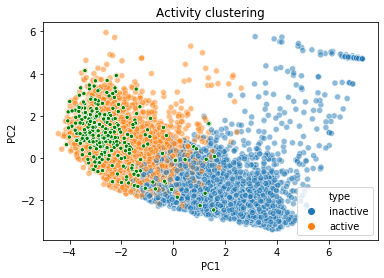

In [9]:
# Plot PC1 and PC2
%matplotlib inline
plt.figure()
sns.scatterplot(x="PC1", y="PC2", data=df_clusters, hue="type", alpha=0.5)
sns.scatterplot(x="PC1", y="PC2", data=df_clusters[df_clusters['adhesome_locus']==1], 
                size=0.1, color='green',legend=False)
plt.title('Activity clustering')
plt.show()

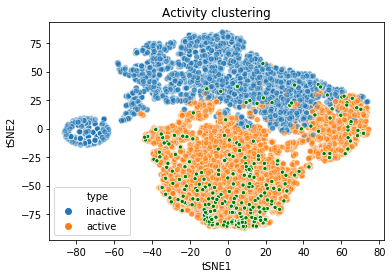

In [10]:
# Plot tSNE1 and tSNE2
%matplotlib inline
plt.figure()
sns.scatterplot(x="tSNE1", y="tSNE2", data=df_clusters, hue="type", alpha=0.5)
sns.scatterplot(x="tSNE1", y="tSNE2", data=df_clusters[df_clusters['adhesome_locus']==1], 
                size=0.1, color='green',legend=False)
plt.title('Activity clustering')
plt.show()

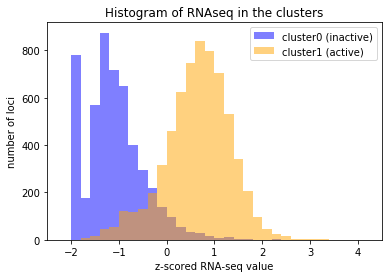

In [11]:
# Distribution of RNAseq in clusters
%matplotlib inline
plt.figure()
plt.hist(df_clusters.loc[df_clusters['cluster']==0]['RNAseq'], bins=np.arange(-2,4,0.2), 
         color='blue', alpha=0.5, density=False, label='cluster0 (inactive)')
plt.hist(df_clusters.loc[df_clusters['cluster']==1]['RNAseq'], bins=np.arange(-2,4,0.2), 
         color='orange', alpha=0.5, density=False, label='cluster1 (active)')
#plt.scatter(df_clusters[(df_clusters['adhesome_locus']==1) & (df_clusters['cluster']==0)]['RNAseq'], 
#            np.zeros(n_adhesome_inactive)-20, color='blue', alpha=0.5, s=1)
#plt.scatter(df_clusters[(df_clusters['adhesome_locus']==1) & (df_clusters['cluster']==1)]['RNAseq'], 
#            np.zeros(n_adhesome_active)-10, color='orange', alpha=0.5, s=1)
plt.xlim(-2.5,4.5)
plt.xlabel('z-scored RNA-seq value')
plt.ylabel('number of loci')
plt.title('Histogram of RNAseq in the clusters')
plt.legend(loc='upper right')
plt.show()

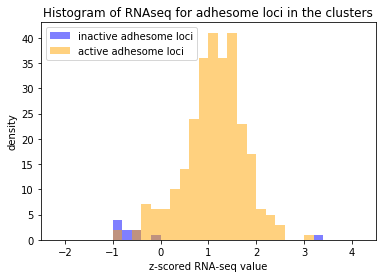

In [12]:
# Distribution of RNA-seq in clusters for adhesome loci only
%matplotlib inline
plt.figure()
plt.hist(df_clusters[(df_clusters['adhesome_locus']==1) & (df_clusters['cluster']==0)]['RNAseq'], bins=np.arange(-1,4,0.2), 
         color='blue', alpha=0.5, density=False, label='inactive adhesome loci')
plt.hist(df_clusters[(df_clusters['adhesome_locus']==1) & (df_clusters['cluster']==1)]['RNAseq'], bins=np.arange(-1,4,0.2), 
         color='orange', alpha=0.5, density=False, label='active adhesome loci')
plt.xlim(-2.5,4.5)
plt.xlabel('z-scored RNA-seq value')
plt.ylabel('density')
plt.title('Histogram of RNAseq for adhesome loci in the clusters')
plt.legend(loc='upper left')
plt.show()

In [13]:
# Save all active/inactive loci to pickle
all_active_loci = df_clusters[df_clusters['type']=='active'].index.tolist()
pickle.dump(all_active_loci ,open(saving_dir+'all_active_loci.pkl', 'wb'), protocol=pickle.HIGHEST_PROTOCOL)
all_inactive_loci = df_clusters[df_clusters['type']=='inactive'].index.tolist()
pickle.dump(all_inactive_loci ,open(saving_dir+'all_inactive_loci.pkl', 'wb'), protocol=pickle.HIGHEST_PROTOCOL)

### Import adhesome loci

In [14]:
# Load adhesome components data
adhesome_components_filename = dir_adhesome+'components.csv'
df_components = lu.load_adhesome_data(adhesome_components_filename)
# Load gene location in hg19
gene_locations_filename = dir_genome+'chrom_hg19.loc_canonical'
gene_id_filename = dir_genome+'chrom_hg19.name'
df_loc = lu.get_gene_locations(gene_locations_filename, gene_id_filename)
# Find location of adhesome genes
adhesome_loc_df, missing_adhesome_genes = lu.get_adhesome_genes_location(df_components, df_loc)
adhesome_loc_df = lu.get_adhesome_genes_loci(adhesome_loc_df, resol)
adhesome_loc_df['chrom_int'] = adhesome_loc_df['chrom'].str.split('chr').str[1].astype(int)
adhesome_genes = np.unique(adhesome_loc_df['gene'])
print('Final number of adhesome genes = '+str(len(adhesome_genes)))
# Construct data frame annotating each adhesome locus with gene
adhesome_chr_loci = adhesome_loc_df[['chrom','chrom_int','loci','gene']]
adhesome_chr_loci = adhesome_chr_loci.sort_values(['chrom_int','loci'])
adhesome_loci = [adhesome_chr_loci.iloc[i]['chrom']+'_'+'loc'+str(adhesome_chr_loci.iloc[i]['loci']*resol) 
                 for i in range(len(adhesome_chr_loci))]
# Add locus ID column
adhesome_chr_loci['locus_id'] = ['chr_'+str(adhesome_chr_loci.iloc[i]['chrom_int'])+'_loc_'
                                 +str(adhesome_chr_loci.iloc[i]['loci']*resol) 
                                 for i in range(len(adhesome_chr_loci))]
pickle.dump(adhesome_chr_loci, open(saving_dir+'adhesome_chr_loci.pkl', 'wb'))
# Visualize head of adhesome_chr_loci
print('Number of adhesome loci = '+str(len(adhesome_loci)))
adhesome_chr_loci.head()

Adhesome genes absent from UCSC genes: ['MSN', 'GRLF1', 'ITGAW', 'FLNA', 'PPP2CA', 'SMPX', 'DDEF1', 'JUB', 'ARHGEF6', 'SH3KBP1']
Final number of adhesome genes = 222
Number of adhesome loci = 305


,chrom,chrom_int,loci,gene,locus_id
34,chr1,1,64,FBLIM1,chr_1_loc_16000000
97,chr1,1,95,ASAP3,chr_1_loc_23750000
173,chr1,1,109,SLC9A1,chr_1_loc_27250000
158,chr1,1,127,FABP3,chr_1_loc_31750000
139,chr1,1,158,MACF1,chr_1_loc_39500000


In [15]:
# List of all adhesome genes
all_adhesome_genes = np.unique(adhesome_chr_loci['gene'].values)
pickle.dump(all_adhesome_genes ,open(saving_dir+'all_adhesome_genes.pkl', 'wb'), protocol=pickle.HIGHEST_PROTOCOL)

In [16]:
adhesome_chr_loci.head()

,chrom,chrom_int,loci,gene,locus_id
34,chr1,1,64,FBLIM1,chr_1_loc_16000000
97,chr1,1,95,ASAP3,chr_1_loc_23750000
173,chr1,1,109,SLC9A1,chr_1_loc_27250000
158,chr1,1,127,FABP3,chr_1_loc_31750000
139,chr1,1,158,MACF1,chr_1_loc_39500000


In [17]:
# Dictionary with adhesome locus as key and adhesome gene as value
adhesome_chr_loci_bis = adhesome_chr_loci.groupby('locus_id')['gene'].apply(lambda x: '_'.join(x)).reset_index()
adhesome_locus_gene_dict = {adhesome_chr_loci_bis.iloc[i,0]:adhesome_chr_loci_bis.iloc[i,1] 
                            for i in np.arange(len(adhesome_chr_loci_bis))}
# Dictionary with adhesome gene as key and adhesome locus as value
adhesome_chr_loci_ter = adhesome_chr_loci.groupby('gene')['locus_id'].apply(lambda x: '_x_'.join(x)).reset_index()
adhesome_gene_locus_dict = {adhesome_chr_loci_ter.iloc[i,0]:adhesome_chr_loci_ter.iloc[i,1] 
                            for i in np.arange(len(adhesome_chr_loci_ter))}

### Identify active/inactive adhesome loci

In [18]:
# Load annotated loci across all genome
df_clusters = pickle.load(open(saving_dir+'active_inactive_loci.pkl', 'rb'))
df_clusters.head()

,H3K4me1,H3K4me2,H3K4me3,H3K36me3,H3K9ac,POLR2A,H3K9me3,H3K27me3,RNAseq,ATACseq,cluster,PC1,PC2,tSNE1,tSNE2,adhesome_locus,type
chr_1_loc_0,-1.008735,-1.958933,-0.762508,-0.846516,-2.030991,-0.789470,-4.012477,-0.207024,-0.580582,-0.649909,0,3.604792,2.546615,-48.559505,18.347490,0,inactive
chr_1_loc_250000,-2.015639,-1.958933,-1.559915,-1.915456,-3.572735,-0.789470,-6.973887,-1.800421,-1.212921,-1.994005,0,7.062331,4.800447,-65.415192,7.989654,0,inactive
chr_1_loc_500000,-0.505283,-0.780395,-0.296056,0.502253,-1.408623,0.148832,-3.677000,-1.297760,0.481148,-1.994005,0,2.204047,2.981675,-42.624043,16.534678,0,inactive
chr_1_loc_750000,0.796121,0.903726,2.096163,1.085439,1.086720,3.123182,-0.596838,0.641495,1.608928,1.160163,1,-4.107282,1.795891,-8.953670,-84.428932,0,active
chr_1_loc_1000000,0.699133,0.629325,2.047202,0.909434,1.328125,2.327504,-0.485287,0.407424,1.932739,1.077385,1,-3.888290,1.491828,-9.167767,-81.599449,0,active


In [19]:
# All loci in genome
all_loci = set(df_clusters.index)
pickle.dump(all_loci ,open(saving_dir+'all_loci.pkl', 'wb'), protocol=pickle.HIGHEST_PROTOCOL)
print('Total number of loci in genome = '+str(len(all_loci)))
# Active loci correspond to cluster 1
active_loci = list(df_clusters[df_clusters['cluster']==1].index)
pickle.dump(active_loci ,open(saving_dir+'active_loci.pkl', 'wb'), protocol=pickle.HIGHEST_PROTOCOL)
print('Number of active loci in genome: '+str(len(active_loci)))
# Inactive loci correspond to cluster 0
inactive_loci = list(df_clusters[df_clusters['cluster']==0].index)
pickle.dump(inactive_loci ,open(saving_dir+'inactive_loci.pkl', 'wb'), protocol=pickle.HIGHEST_PROTOCOL)
print('Number of inactive loci in genome: '+str(len(inactive_loci)))

Total number of loci in genome = 11537
Number of active loci in genome: 6452
Number of inactive loci in genome: 5085


In [20]:
# Dictionary of active loci for each chromosome
active_loci_dict = dict()
for chrom in range(1,22+1):
    active_loci_dict[chrom] = ([int(s.split('_')[3]) for s in active_loci if 'chr_'+str(chrom)+'_' in s])
pickle.dump(active_loci_dict ,open(saving_dir+'active_loci_dict.pkl', 'wb'), protocol=pickle.HIGHEST_PROTOCOL)

In [21]:
# Identify all/active/inactive adhesome genes in the genome
pickle.dump(adhesome_genes ,open(saving_dir+'adhesome_genes_list.pkl', 'wb'), protocol=pickle.HIGHEST_PROTOCOL)
active_adhesome_genes = np.unique(adhesome_chr_loci[adhesome_chr_loci['locus_id'].isin(active_loci)]['gene'].values)
pickle.dump(active_adhesome_genes ,open(saving_dir+'active_adhesome_genes.pkl', 'wb'), protocol=pickle.HIGHEST_PROTOCOL)
inactive_adhesome_genes = np.unique(adhesome_chr_loci[adhesome_chr_loci['locus_id'].isin(inactive_loci)]['gene'].values)
pickle.dump(inactive_adhesome_genes ,open(saving_dir+'inactive_adhesome_genes.pkl', 'wb'), protocol=pickle.HIGHEST_PROTOCOL)

### Active/inactive adhesome loci per chromosome

In [22]:
# Add activity column to adhesome_chr_loci
adhesome_chr_loci['active'] = [adhesome_chr_loci.iloc[i]['locus_id'] in active_loci 
                               for i in range(len(adhesome_chr_loci))]
adhesome_chr_loci.to_csv(saving_dir+'adhesome_loci_activity.csv', header=True)
pickle.dump(adhesome_chr_loci ,open(saving_dir+'adhesome_chr_loci.pkl', 'wb'), protocol=pickle.HIGHEST_PROTOCOL)

In [23]:
# All adhesome loci
adhesome_chr_loci_unique = adhesome_chr_loci.drop_duplicates(subset='locus_id')
adhesome_loci_list = adhesome_chr_loci_unique['locus_id'].tolist()
pickle.dump(adhesome_loci_list ,open(saving_dir+'adhesome_loci_list.pkl', 'wb'), protocol=pickle.HIGHEST_PROTOCOL)
# Active adhesome loci
active_adhesome_loci = adhesome_chr_loci_unique[adhesome_chr_loci_unique['active']==True]['locus_id'].values
pickle.dump(active_adhesome_loci ,open(saving_dir+'active_adhesome_loci.pkl', 'wb'), protocol=pickle.HIGHEST_PROTOCOL)
# Inactive adhesome loci
inactive_adhesome_loci = adhesome_chr_loci_unique[adhesome_chr_loci_unique['active']==False]['locus_id'].values
pickle.dump(inactive_adhesome_loci ,open(saving_dir+'inactive_adhesome_loci.pkl', 'wb'), protocol=pickle.HIGHEST_PROTOCOL)

Number of active adhesome loci = 281
Number of inactive adhesome loci = 16


<Figure size 432x288 with 0 Axes>

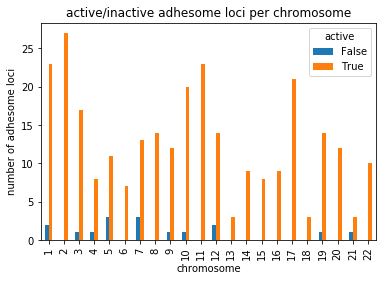

In [24]:
# Basic statistics
print('Number of active adhesome loci = '+str(len(active_adhesome_loci)))
print('Number of inactive adhesome loci = '+str(len(inactive_adhesome_loci)))
# Plot number of active/inactive adhesome loci for all chromosomes
df_bar = adhesome_chr_loci_unique.groupby(['chrom_int'])
df_bar1 = df_bar['active'].value_counts().unstack()
plt.figure()
df_bar1.plot(kind='bar', title='active/inactive adhesome loci per chromosome')
plt.xlabel('chromosome')
plt.ylabel('number of adhesome loci')
plt.show()

### Compare to random loci

In [25]:
# Create a dictionary of all non-adhesome, non adhesome-targeting TF active loci for each chromosome
all_active_loci_without_adhesome = list(set(active_loci)-set(active_adhesome_loci))
active_loci_pool = {chrom: [locus for locus in all_active_loci_without_adhesome if (int(locus.split('_')[1])==chrom)] 
                    for chrom in np.arange(1,22+1,1)}
# Create a dictionary of all non-adhesome, non adhesome-targeting TF iactive loci for each chromosome
all_inactive_loci_without_adhesome = list(set(inactive_loci)-set(inactive_adhesome_loci))
inactive_loci_pool = {chrom: [locus for locus in all_inactive_loci_without_adhesome if (int(locus.split('_')[1])==chrom)] 
                    for chrom in np.arange(1,22+1,1)}

In [26]:
# List of all active adhesome genes
number_active_adhesome_per_chrom = {chrom: len([locus for locus in active_adhesome_loci if (int(locus.split('_')[1])==chrom)])
                                  for chrom in np.arange(1,22+1,1)}
number_inactive_adhesome_per_chrom = {chrom: len([locus for locus in inactive_adhesome_loci if (int(locus.split('_')[1])==chrom)])
                                  for chrom in np.arange(1,22+1,1)}

In [27]:
# Create list out of all adhesome and random groups of loci
random_active_non_adhesome_loci = np.array(pickle.load(open(saving_dir+'random_active_non_adhesome_loci.pkl', 'rb')))
random_inactive_non_adhesome_loci = np.array(pickle.load(open(saving_dir+'random_inactive_non_adhesome_loci.pkl', 'rb')))
# Group all loci list by chromosome
active_adhesome_loci = active_adhesome_loci[np.argsort([int(locus.split('_')[1]) for locus in active_adhesome_loci])]
inactive_adhesome_loci = inactive_adhesome_loci[np.argsort([int(locus.split('_')[1]) for locus in inactive_adhesome_loci])]
random_active_non_adhesome_loci = random_active_non_adhesome_loci[np.argsort([int(locus.split('_')[1]) for locus in random_active_non_adhesome_loci])]
random_inactive_non_adhesome_loci = random_inactive_non_adhesome_loci[np.argsort([int(locus.split('_')[1]) for locus in random_inactive_non_adhesome_loci])]
# Create combined list
loci_list = list(itertools.chain.from_iterable([active_adhesome_loci,
                                                inactive_adhesome_loci,
                                                random_active_non_adhesome_loci,
                                                random_inactive_non_adhesome_loci]))

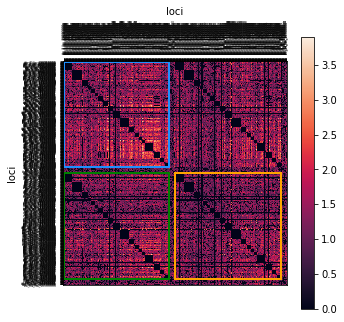

In [28]:
# Load contacts_df1
contacts_df1 = pickle.load(open(saving_dir+'contacts_df1.pkl', 'rb'))
# Plot data frame as heatmap
patches_list = [[0,1,len(active_adhesome_loci), len(active_adhesome_loci),'dodgerblue'],
                [len(active_adhesome_loci)+len(inactive_adhesome_loci),len(active_adhesome_loci)+len(inactive_adhesome_loci),len(active_adhesome_loci),len(active_adhesome_loci),'orange'],
                [0, len(active_adhesome_loci)+len(inactive_adhesome_loci),len(random_active_non_adhesome_loci),len(random_active_non_adhesome_loci),'green']]
lu.plot_heatmap(contacts_df1, loci_list, loci_list, 'loci', 'loci', 
                5, contacts_df1.max().max(), add_patches = patches_list)

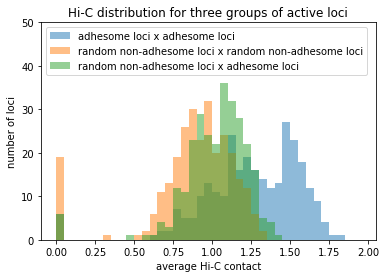

Wilcoxon Rank-Sums test:
RanksumsResult(statistic=13.98403678358168, pvalue=1.951003771722823e-44)


In [29]:
# Histogram of average Hi-C contacts in three active cases
# Group of active adhesome loci with itself
active_adhesome_hic_with_itself = contacts_df1.loc[active_adhesome_loci,active_adhesome_loci].mean(axis=1)
# Group of random active non-adhesome loci with itself
random_active_adhesome_hic_with_itself = contacts_df1.loc[random_active_non_adhesome_loci,random_active_non_adhesome_loci].mean(axis=1)
# Group of random active non-adhesome loci with active adhesome loci
random_versus_adhesome_active = contacts_df1.loc[active_adhesome_loci,random_active_non_adhesome_loci].mean(axis=1)
# Histogram
plt.figure()
plt.hist(active_adhesome_hic_with_itself, 
         bins=np.arange(0,2,0.05), alpha=0.5, density=False, label='adhesome loci x adhesome loci')
plt.hist(random_active_adhesome_hic_with_itself, 
         bins=np.arange(0,2,0.05), alpha=0.5, density=False, label='random non-adhesome loci x random non-adhesome loci')
plt.hist(random_versus_adhesome_active, 
         bins=np.arange(0,2,0.05), alpha=0.5, density=False, label='random non-adhesome loci x adhesome loci')
plt.xlabel('average Hi-C contact')
plt.ylabel('number of loci')
plt.title('Hi-C distribution for three groups of active loci')
plt.ylim(0,50)
plt.legend(loc='upper left')
plt.show()
print('Wilcoxon Rank-Sums test:')
print(ss.ranksums(active_adhesome_hic_with_itself.values,
                  random_active_adhesome_hic_with_itself))

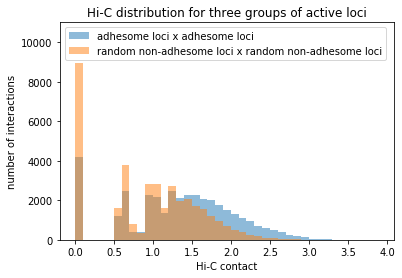

In [30]:
# Histogram of average Hi-C contacts in three active cases
indices = np.triu_indices(len(contacts_df1.loc[active_adhesome_loci,active_adhesome_loci]))
num_zeros_intraX = sum([int(number_active_adhesome_per_chrom[chrom]*(number_active_adhesome_per_chrom[chrom]+1)/2)
                        for chrom in np.arange(1,22+1,1)])
# Group of active adhesome loci with itself
active_adhesome_hic_with_itself = sorted(contacts_df1.loc[active_adhesome_loci,
                                                   active_adhesome_loci].values[indices])[num_zeros_intraX:]
# Group of random active non-adhesome loci with itself
random_active_adhesome_hic_with_itself = sorted(contacts_df1.loc[random_active_non_adhesome_loci,
                                                          random_active_non_adhesome_loci].values[indices])[num_zeros_intraX:]
# Group of random active non-adhesome loci with active adhesome loci
random_versus_adhesome_active = sorted(contacts_df1.loc[active_adhesome_loci,
                                                 random_active_non_adhesome_loci].values[indices])[num_zeros_intraX:]
# Histogram
plt.figure()
plt.hist(active_adhesome_hic_with_itself, 
         bins=np.arange(0,4,0.1), alpha=0.5, density=False, label='adhesome loci x adhesome loci')
plt.hist(random_active_adhesome_hic_with_itself, 
         bins=np.arange(0,4,0.1), alpha=0.5, density=False, label='random non-adhesome loci x random non-adhesome loci')
#plt.vlines(x=1.5, ymin=0, ymax=9000, color='red', linestyle='dashed')
plt.xlabel('Hi-C contact')
plt.ylabel('number of interactions')
plt.title('Hi-C distribution for three groups of active loci')
plt.ylim(0,11000)
plt.legend(loc='upper left')
plt.show()

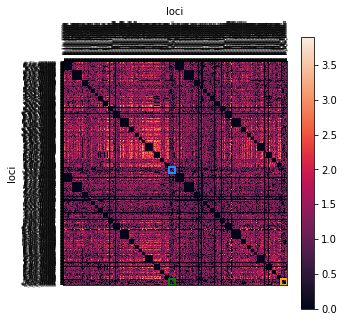

In [31]:
# Load contacts_df1
contacts_df1 = pickle.load(open(saving_dir+'contacts_df1.pkl', 'rb'))
# Plot data frame as heatmap
patches_list = [[len(active_adhesome_loci), len(active_adhesome_loci),len(inactive_adhesome_loci),len(inactive_adhesome_loci),'dodgerblue'],
                [len(active_adhesome_loci)+len(inactive_adhesome_loci)+len(random_active_non_adhesome_loci),len(active_adhesome_loci)+len(inactive_adhesome_loci)+len(random_active_non_adhesome_loci),len(random_inactive_non_adhesome_loci),len(random_inactive_non_adhesome_loci),'orange'],
                [len(active_adhesome_loci),len(active_adhesome_loci)+len(inactive_adhesome_loci)+len(random_active_non_adhesome_loci),len(random_inactive_non_adhesome_loci),len(random_inactive_non_adhesome_loci),'green']]
lu.plot_heatmap(contacts_df1, loci_list, loci_list, 'loci', 'loci', 
                5, contacts_df1.max().max(), add_patches = patches_list)

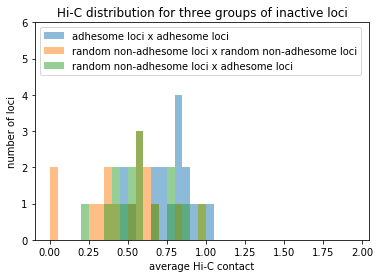

Wilcoxon Rank-Sums test:
RanksumsResult(statistic=3.0528023638498567, pvalue=0.0022671520041358897)


In [32]:
# Histogram of average Hi-C contacts in three inactive cases
# Group of inactive adhesome loci with itself
inactive_adhesome_hic_with_itself = contacts_df1.loc[inactive_adhesome_loci,inactive_adhesome_loci].mean(axis=1)
# Group of random inactive non-adhesome loci with itself
random_inactive_adhesome_hic_with_itself = contacts_df1.loc[random_inactive_non_adhesome_loci,random_inactive_non_adhesome_loci].mean(axis=1)
# Group of random inactive non-adhesome loci with inactive adhesome loci
random_versus_adhesome_inactive = contacts_df1.loc[inactive_adhesome_loci,random_inactive_non_adhesome_loci].mean(axis=1)
# Histogram
plt.figure()
plt.hist(inactive_adhesome_hic_with_itself, 
         bins=np.arange(0,2,0.05), alpha=0.5, density=False, label='adhesome loci x adhesome loci')
plt.hist(random_inactive_adhesome_hic_with_itself, 
         bins=np.arange(0,2,0.05), alpha=0.5, density=False, label='random non-adhesome loci x random non-adhesome loci')
plt.hist(random_versus_adhesome_inactive, 
         bins=np.arange(0,2,0.05), alpha=0.5, density=False, label='random non-adhesome loci x adhesome loci')
plt.xlabel('average Hi-C contact')
plt.ylabel('number of loci')
plt.title('Hi-C distribution for three groups of inactive loci')
plt.ylim(0,6)
plt.legend(loc='upper left')
plt.show()
print('Wilcoxon Rank-Sums test:')
print(ss.ranksums(inactive_adhesome_hic_with_itself.values,
                  random_inactive_adhesome_hic_with_itself))

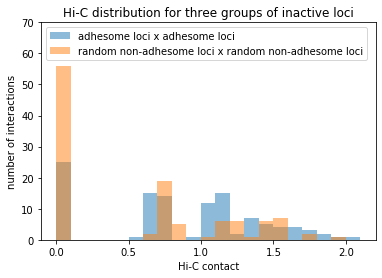

In [33]:
# Histogram of average Hi-C contacts in three active cases
indices = np.triu_indices(len(contacts_df1.loc[inactive_adhesome_loci,inactive_adhesome_loci]))
num_zeros_intraX = sum([int(number_inactive_adhesome_per_chrom[chrom]*(number_inactive_adhesome_per_chrom[chrom]+1)/2)
                        for chrom in np.arange(1,22+1,1)])
# Group of active adhesome loci with itself
inactive_adhesome_hic_with_itself = sorted(contacts_df1.loc[inactive_adhesome_loci,
                                                   inactive_adhesome_loci].values[indices])[num_zeros_intraX:]
# Group of random active non-adhesome loci with itself
random_inactive_adhesome_hic_with_itself = sorted(contacts_df1.loc[random_inactive_non_adhesome_loci,
                                                          random_inactive_non_adhesome_loci].values[indices])[num_zeros_intraX:]
# Histogram
plt.figure()
plt.hist(inactive_adhesome_hic_with_itself, 
         bins=np.arange(0,2.2,0.1), alpha=0.5, density=False, label='adhesome loci x adhesome loci')
plt.hist(random_inactive_adhesome_hic_with_itself, 
         bins=np.arange(0,2.2,0.1), alpha=0.5, density=False, label='random non-adhesome loci x random non-adhesome loci')
plt.xlabel('Hi-C contact')
plt.ylabel('number of interactions')
plt.title('Hi-C distribution for three groups of inactive loci')
plt.ylim(0,70)
plt.legend(loc='upper left')
plt.show()

### Supplement: show HiC connections between chromosomes

In [34]:
# Initialize empty dataframe
chr_list = np.arange(1,22+1)
chr_hic_contact = pd.DataFrame(0,index=chr_list, columns=chr_list)

In [35]:
# List all chromosome pairs
chr_pairs = list(itertools.combinations(chr_list, 2))
for pair in tqdm(chr_pairs):
    time.sleep(.01)
    chr1, chr2 = pair
    # Load HiC data for this chromosome pair
    processed_hic_filename = 'hic_'+'chr'+str(chr1)+'_'+'chr'+str(chr2)+'_norm1_filter3'+'.pkl'
    hic_chpair_df = pickle.load(open(dir_processed_hic+processed_hic_filename, 'rb'))
    # Fill chr_hic_contact with the average Hi-C contact between chr1 and chr2
    chr_hic_contact.loc[chr1,chr2] = hic_chpair_df.mean().mean()
    chr_hic_contact.loc[chr2,chr1] = hic_chpair_df.mean().mean()

100%|██████████| 231/231 [00:03<00:00, 71.61it/s]


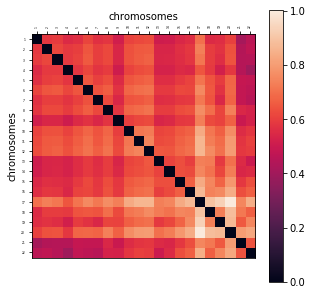

In [36]:
# Plot average HiC contact between all pairs of chromosomes
lu.plot_heatmap(chr_hic_contact, chr_list, chr_list, 'chromosomes', 'chromosomes', 
                5, chr_hic_contact.max().max())

### Network of adhesome genes: interX edges

### Network of adhesome genes: intraX edges

### Network of adhesome genes: interX and intraX

In [37]:
# Load edge lists
adhesome_interX_edge_list = pickle.load(open(saving_dir+'adhesome_interX_edge_list.pkl', 'rb'))
adhesome_intraX_edge_list = pickle.load(open(saving_dir+'adhesome_intraX_edge_list.pkl', 'rb'))

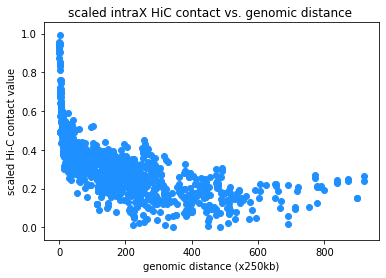

In [39]:
# Plot HiC as a function of genomic distance fo all intraX edges
plt.figure()
plt.scatter(adhesome_intraX_edge_list['gen_dist'],
            adhesome_intraX_edge_list['scaled_hic'], 
            color='dodgerblue', label='all intraX contacts')
# plt.hlines(y=0.5, xmin=0, xmax=900, color='red', linestyle='dashed')
plt.xlabel('genomic distance (x250kb)')
plt.ylabel('scaled Hi-C contact value')
plt.title('scaled intraX HiC contact vs. genomic distance ')
plt.show()

### Robustness of VOTE clustering
- Implement 25 iterations of vote from different permutations
- Obtain the different clusterings and compute adjusted mutual information between them

In [41]:
# Select all interX edges
adhesome_edge_list = adhesome_interX_edge_list[adhesome_interX_edge_list['scaled_hic']>0]
# Create corresponding network
G = nx.from_pandas_edgelist(adhesome_edge_list, edge_attr=['hic','scaled_hic'])
#G.add_nodes_from(active_adhesome_genes)
# Get cost matrices
A, w_plus, w_minus, w_pm = cc.compute_costs(G, 'scaled_hic')
n = G.number_of_nodes()
# Run VOTE
n_runs = 20
clustering_dict_ls = []
for i in tqdm(range(n_runs)):
    time.sleep(.01)
    vote_dict,objective_vals = cc.VOTE_notqdm(n, w_minus, w_plus, w_pm, n_runs=25, seed=13*i)
    clustering_dict_ls.append(vote_dict)

100%|██████████| 20/20 [00:39<00:00,  2.00s/it]


100%|██████████| 190/190 [00:10<00:00, 17.44it/s]


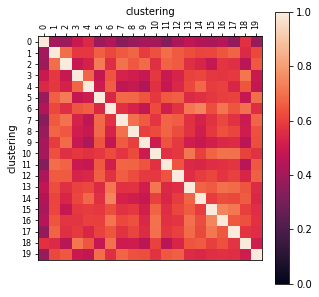

In [115]:
# Compute adjusted mutual information between all clusterings
adj_mi_df = pd.DataFrame(1,index=range(n_runs), columns=range(n_runs))
for (t1,t2) in tqdm(list(itertools.combinations(range(n_runs),2))):
    time.sleep(.01)
    adj_mi_df.loc[t1,t2] = adjusted_mutual_info_score(labels_true=list(clustering_dict_ls[t1].values()),
                                                      labels_pred=list(clustering_dict_ls[t2].values()), 
                                                      average_method='min')
    adj_mi_df.loc[t2,t1] = adj_mi_df.loc[t1,t2]
# Plot heatmap
lu.plot_heatmap(adj_mi_df, range(n_runs), range(n_runs), 'clustering', 'clustering', 5, 1, 8)

### Clustering at different HiC thresholds

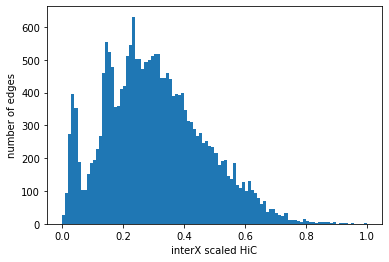

In [40]:
# Histogram of scaled HiC for interX edges
plt.figure()
plt.hist(adhesome_interX_edge_list['scaled_hic'].values, bins=np.arange(0,1.01, 0.01))
plt.xlabel('interX scaled HiC')
plt.ylabel('number of edges')
plt.show()

In [41]:
# Load clusterings_df
clusterings_df = pickle.load(open(saving_dir+'clusterings_df.pkl', 'rb'))

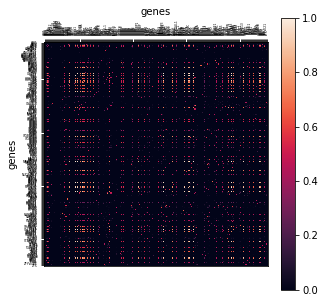

In [42]:
# Plot heatmap of coclustering frequency
cocluster_nodes_df = pickle.load(open(saving_dir+'cocluster_nodes_df.pkl', 'rb'))
lu.plot_heatmap(cocluster_nodes_df, active_adhesome_genes, active_adhesome_genes, 'genes', 'genes', 5, 1, 3)

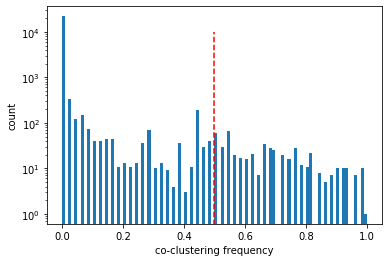

In [43]:
# Plot histogram of coclustering frequencies
cocluster_nodes_mat = np.array(cocluster_nodes_df)
plt.figure()
plt.hist(list(cocluster_nodes_mat[np.triu_indices(cocluster_nodes_mat.shape[0],1)]), bins=np.arange(0,1.01,0.01))
plt.vlines(x=0.5, ymin=0, ymax=1e4, color='red', linestyle='dashed')
plt.yscale('log')
plt.xlabel('co-clustering frequency')
plt.ylabel('count')
plt.show()

In [44]:
# Clusters for different frequency thresholds
freq_thresh_ls = np.arange(0,1,0.1)
size_clusters_df = pd.DataFrame(index=freq_thresh_ls, columns=['n_connected components','size_connected_components'])
for t in freq_thresh_ls:
    cG = nx.from_pandas_adjacency(cocluster_nodes_df*(cocluster_nodes_df>t))
    size_clusters_df.loc[t,'n_connected components'] = nx.number_connected_components(cG)
    size_clusters_df.loc[t,'size_connected_components'] = [len(c) for c in list(sorted(nx.connected_components(cG), key=len, reverse=True))]
size_clusters_df

,n_connected components,size_connected_components
0.0,72,"[147, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1..."
0.1,88,"[129, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1..."
0.2,111,"[82, 6, 6, 5, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2,..."
0.3,117,"[51, 11, 6, 6, 5, 5, 5, 5, 4, 3, 3, 2, 2, 2, 2..."
0.4,128,"[38, 9, 6, 5, 5, 5, 5, 5, 3, 3, 3, 3, 3, 3, 2,..."
0.5,159,"[33, 5, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2,..."
0.6,184,"[27, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1,..."
0.7,195,"[25, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,..."
0.8,203,"[16, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,..."
0.9,209,"[11, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,..."


### Hierarchical clustering

In [51]:
int(str.split('chr10', 'chr')[1])

10

In [57]:
# Create network for hierarchical clustering
# Select all interX edges
adhesome_edge_list = adhesome_interX_edge_list[adhesome_interX_edge_list['scaled_hic']>0]
# Create corresponding network
G = nx.from_pandas_edgelist(adhesome_edge_list, edge_attr=['hic','scaled_hic'])
G_nodes = list(G.nodes)
nx.set_node_attributes(G, {G_nodes[i]: int(str.split(adhesome_chr_loci[adhesome_chr_loci['gene']==G_nodes[i]]['chrom'].values[0],'chr')[1]) for i in range(len(G_nodes))}, "chromosome")
# Save graph to pickle
pickle.dump(G, open(saving_dir+'network_for_hclust.pkl', 'wb'))

In [45]:
# Load balanced cut network 
bG = pickle.load(open(saving_dir+'balanced_cut.pkl', 'rb'))
oi.output_networkx_graph_as_interactive_html(bG, filename=saving_dir+"balanced_network.html")

PosixPath('/home/louiscam/projects/gpcr/save/figures/balanced_network.html')

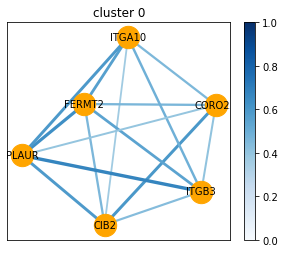

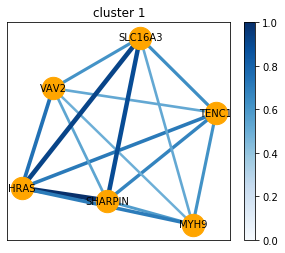

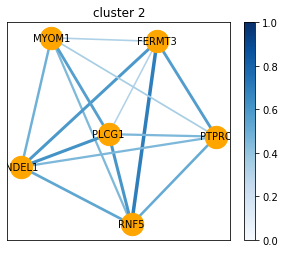

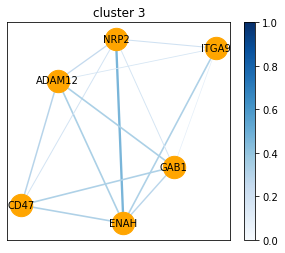

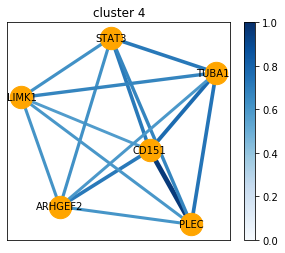

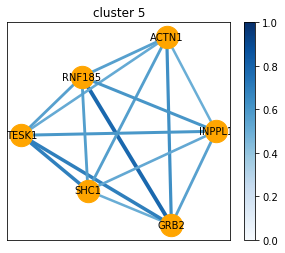

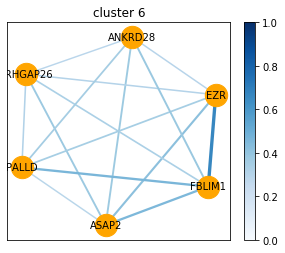

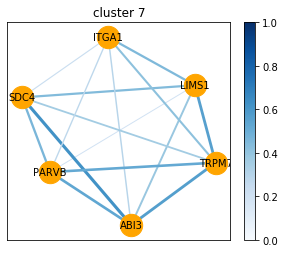

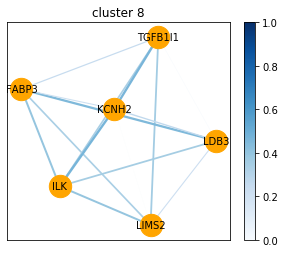

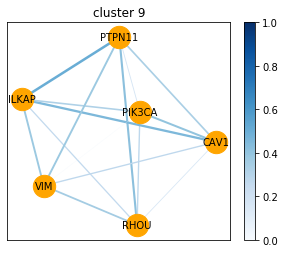

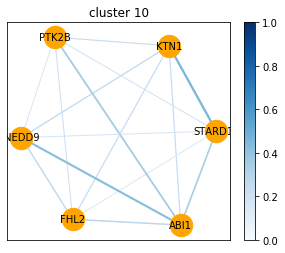

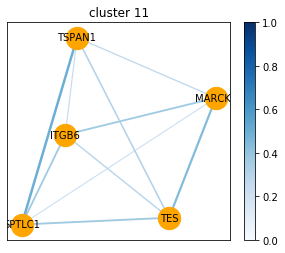

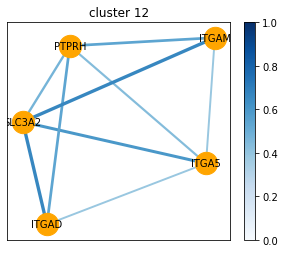

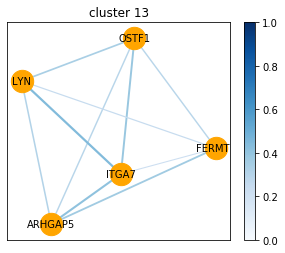

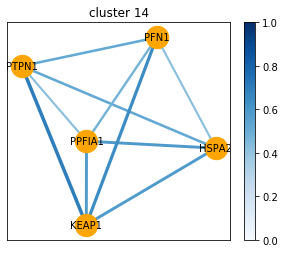

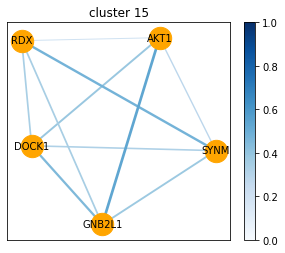

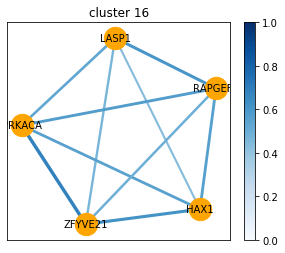

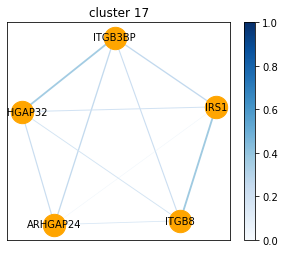

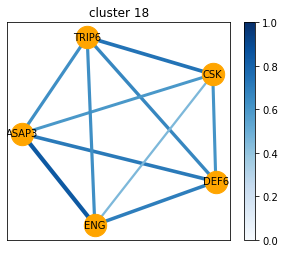

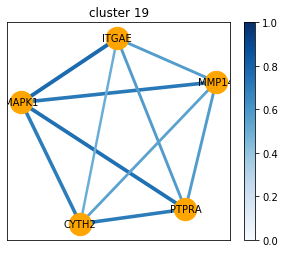

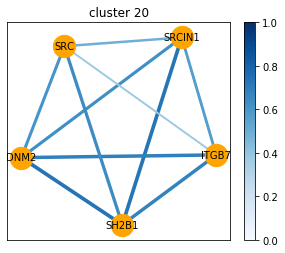

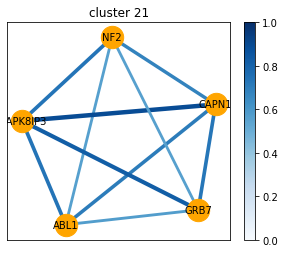

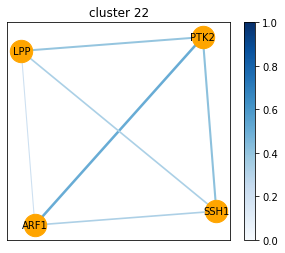

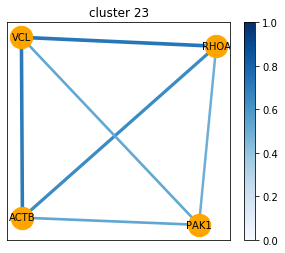

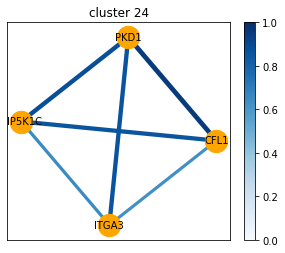

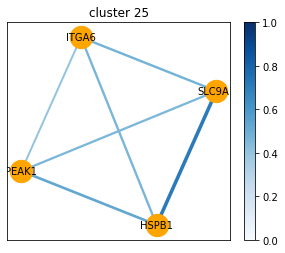

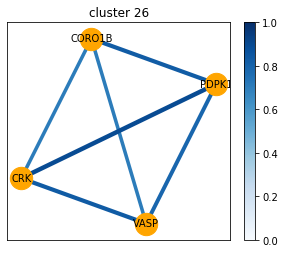

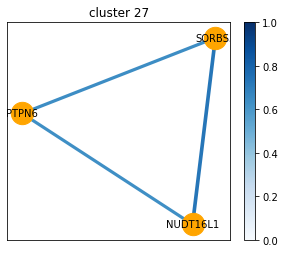

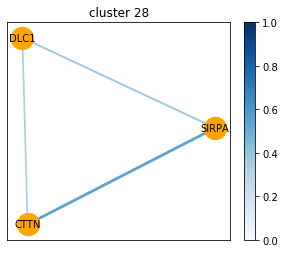

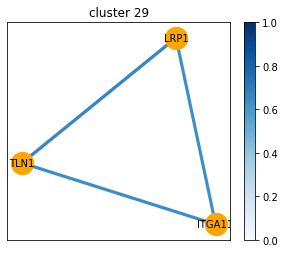

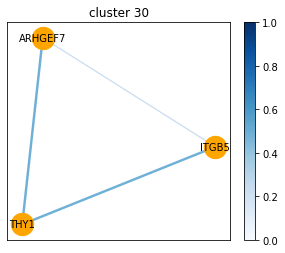

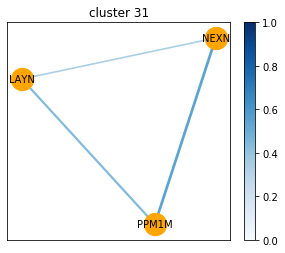

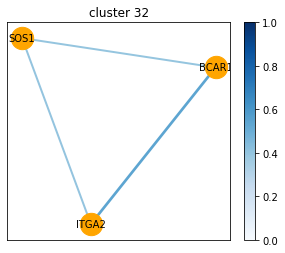

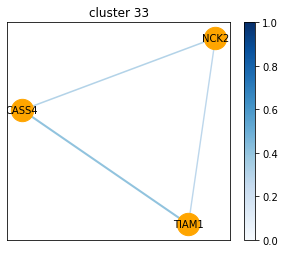

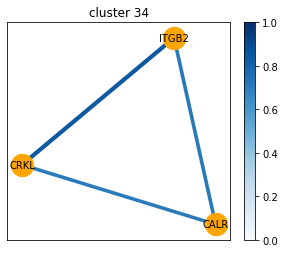

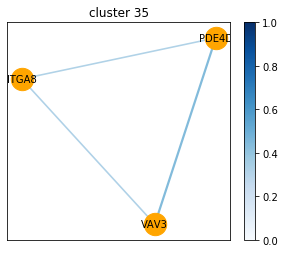

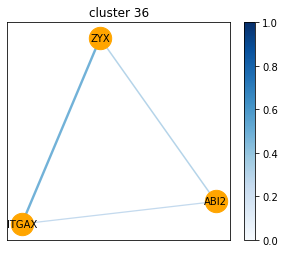

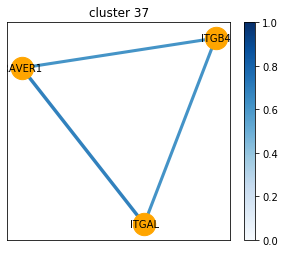

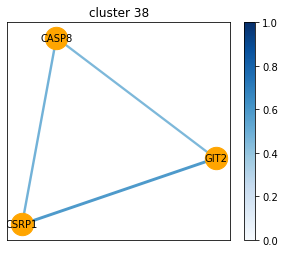

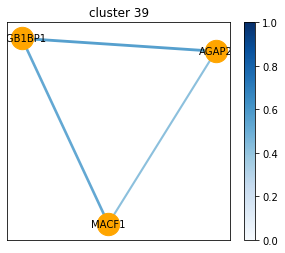

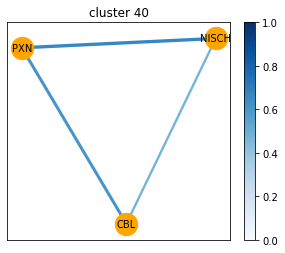

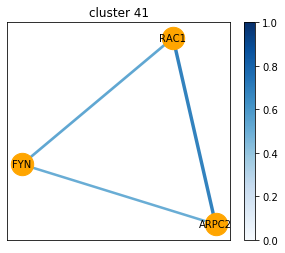

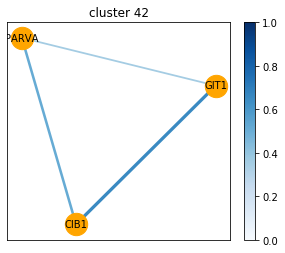

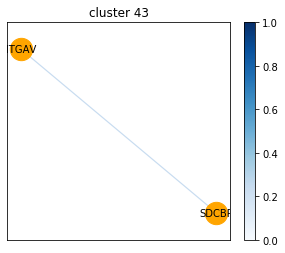

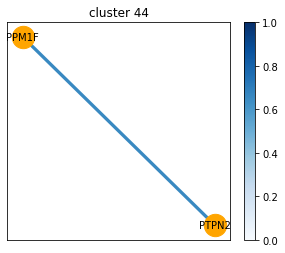

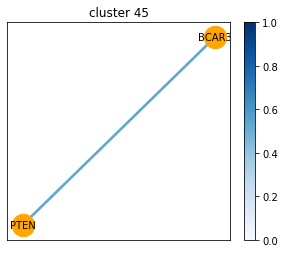

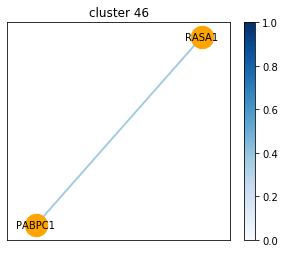

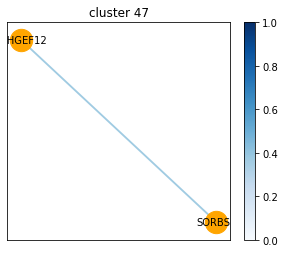

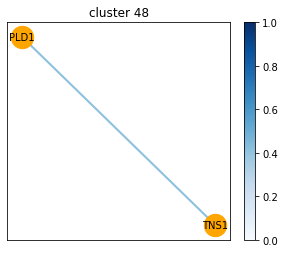

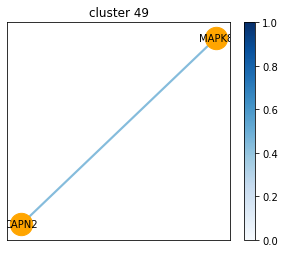

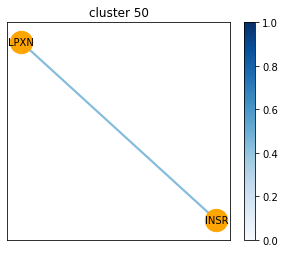

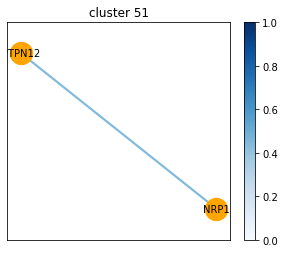

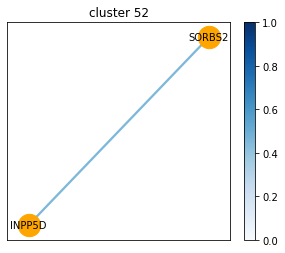

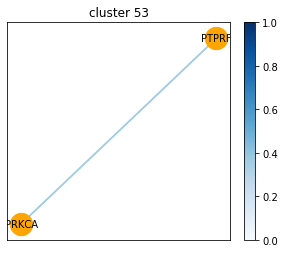

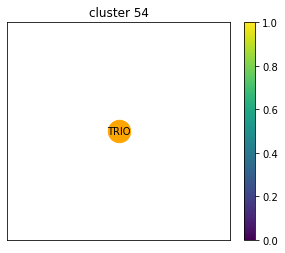

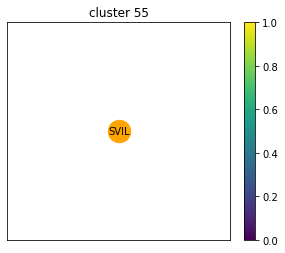

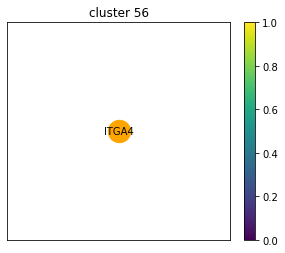

In [46]:
# Plot all clusters
nodes_df = oi.get_networkx_graph_as_dataframe_of_nodes(bG)
n_clusters = len(np.unique(nodes_df['cluster']))
for c in np.arange(n_clusters):
    cluster_tmp = bG.subgraph(nodes_df[nodes_df['cluster']==str(c)].index.values)

    plt.figure(figsize=(5,4))
    pos=nx.spring_layout(cluster_tmp, k=0.1, iterations=20)

    # Plot nodes
    nodes = nx.draw_networkx_nodes(cluster_tmp, pos, 
                                   node_size=500, node_color='orange')
    nx.draw_networkx_labels(cluster_tmp, pos, font_size=10)

    # Plot edges
    edges = nx.draw_networkx_edges(cluster_tmp, pos, 
                           width=5*np.array(list(nx.get_edge_attributes(cluster_tmp,'scaled_hic').values())),
                           edge_cmap=plt.cm.Blues,
                           edge_color=list(nx.get_edge_attributes(cluster_tmp,'scaled_hic').values()),
                           edge_vmin=0, edge_vmax=1)
    plt.colorbar(edges)
    plt.title('cluster '+str(c))
    plt.show()

In [51]:
# Create dataframe of clusters
cluster_dict = dict(bG.nodes(data='cluster'))
clusters_df0 = pd.DataFrame({'gene':list(cluster_dict.keys()), 
                            'cluster':list(cluster_dict.values()),
                            'loci': [adhesome_gene_locus_dict[gene].split('_x_') for gene in cluster_dict.keys()]})
clusters_df = clusters_df0[['gene','cluster']].groupby('cluster')['gene'].apply(list).to_frame()
clusters_df['n_genes'] = [len(cluster) for cluster in clusters_df['gene'].values]
clusters_df = clusters_df[clusters_df['n_genes']>1]
clusters_df = clusters_df.sort_index()
pickle.dump(clusters_df, open(saving_dir+'clusters_fig1.pkl', 'wb'))
print('Number of selected clusters = '+str(len(clusters_df)))

Number of selected clusters = 54


In [52]:
# Create full adhesome gene edge list (no thresholding)
adhesome_intraX_edge_list_2 = adhesome_intraX_edge_list[['source','target','hic','scaled_hic']]
# Select only top interX edges
adhesome_interX_edge_list_2 = adhesome_interX_edge_list
# Combine intraX and interX edge lists
adhesome_edge_list_2 = pd.concat([adhesome_intraX_edge_list_2,adhesome_interX_edge_list_2])
adhesome_edge_list_2 = adhesome_edge_list_2.sort_values(by=['source','target'])
adhesome_edge_list_2 = adhesome_edge_list_2[adhesome_edge_list_2['source']!=adhesome_edge_list_2['target']]

In [54]:
# Create cluster adjacency matrix
selected_clusters = list(clusters_df.index)
cluster_adj = pd.DataFrame(0, columns=selected_clusters, index=selected_clusters)
# Fill out each entry
for i in selected_clusters:
    for j in selected_clusters:
        genes_i = clusters_df.loc[i,'gene']
        genes_j = clusters_df.loc[j,'gene']
        inter_cluster_edges = adhesome_edge_list_2[(adhesome_edge_list_2['source'].isin(genes_i) 
                                                  & adhesome_edge_list_2['target'].isin(genes_j)) |
                                                 (adhesome_edge_list_2['source'].isin(genes_j) 
                                                  & adhesome_edge_list_2['target'].isin(genes_i))]
        cluster_adj.loc[i,j] = inter_cluster_edges['scaled_hic'].values.mean()
# cluster_adj.columns = np.array(selected_clusters, dtype='str')
# cluster_adj.index = np.array(selected_clusters, dtype='str')

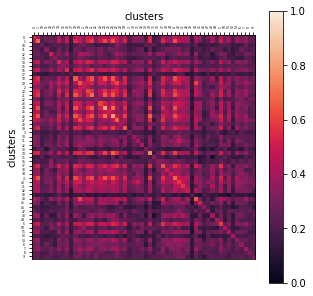

In [55]:
# Visualize connctivity between clusters
lu.plot_heatmap(cluster_adj, selected_clusters, selected_clusters, 'clusters', 'clusters', 
                5,1)

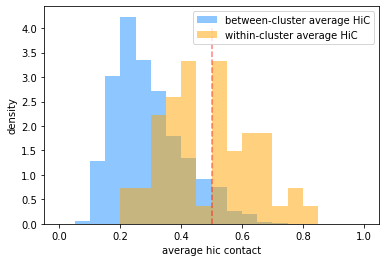

In [63]:
# Visualize histogram of within-cluster average HiC versus between-cluster HI-C
plt.figure()
plt.hist(cluster_adj.values[np.triu_indices(len(cluster_adj),1)], 
         bins=np.arange(0,1.05,0.05), color='dodgerblue', alpha=0.5, label='between-cluster average HiC', density=True)
plt.hist(np.diagonal(cluster_adj), 
         bins=np.arange(0,1.05,0.05), color='orange', alpha=0.5, label='within-cluster average HiC', density=True)
plt.vlines(x=0.5, ymin=0, ymax=4, color='red', linestyle='dashed', alpha=0.5)
plt.xlabel('average hic contact')
plt.ylabel('density')
plt.legend()
plt.show()

In [80]:
# Clusters with high within-to-between HiC ratios
selected_clusters = cluster_adj.index.values[np.where(np.diagonal(cluster_adj)>0.5)[0]]

In [81]:
# Create network of clusters
cluster_adj1 = cluster_adj.copy()
cluster_adj1 = cluster_adj1.loc[selected_clusters,selected_clusters]
np.fill_diagonal(cluster_adj1.values,0)
cluster_adj1 = (cluster_adj1>0.5)*cluster_adj1
clusters_net = nx.from_pandas_adjacency(cluster_adj1)
# Add node attribute: adhesome genes in each cluster
nx.set_node_attributes(clusters_net, {c: clusters_df.loc[c,'gene'] for c in selected_clusters}, "genes")
# Add node attribute: number of adhesome genes in each cluster
nx.set_node_attributes(clusters_net, {c: clusters_df.loc[c,'n_genes'] for c in selected_clusters}, "n_genes")
# Add node attribute: average within-cluster HiC
nx.set_node_attributes(clusters_net, {c: cluster_adj.loc[c,c] for c in selected_clusters}, "avg_hic")

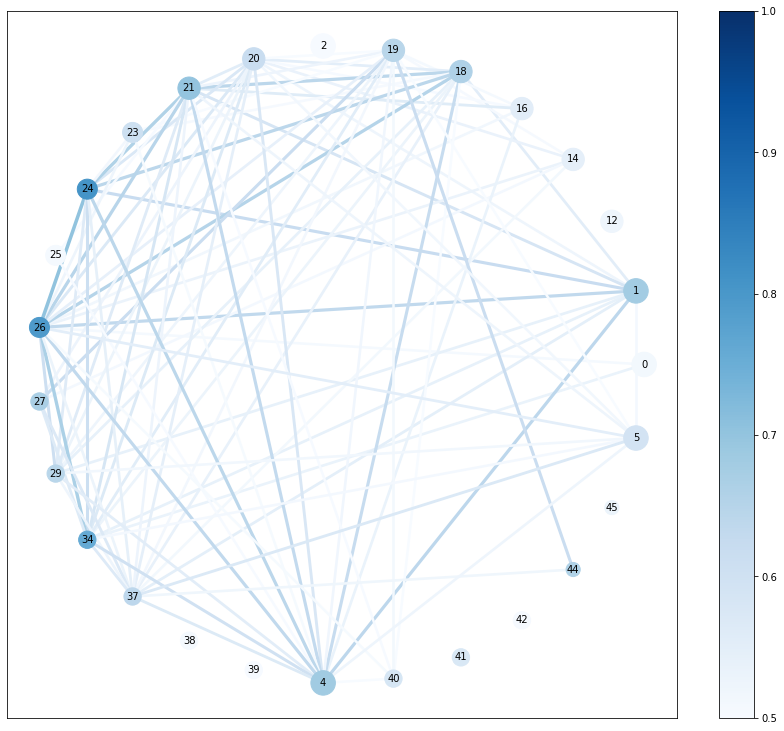

In [86]:
# Visualize big cluster
plt.figure(figsize=(15,13))
pos = nx.circular_layout(clusters_net, scale=2) #nx.spring_layout(clusters_net, k=1, iterations=20)

# Plot nodes
nodes = nx.draw_networkx_nodes(clusters_net, pos, 
                               node_size=100*np.array(list(nx.get_node_attributes(clusters_net,'n_genes').values())),
                               cmap=plt.cm.Blues,
                               node_color = list(nx.get_node_attributes(clusters_net,'avg_hic').values()),
                               vmin=0.5, vmax=1)
nx.draw_networkx_labels(clusters_net, pos, font_size=10)

# Plot edges
edges = nx.draw_networkx_edges(clusters_net, pos, 
                       width=5*np.array(list(nx.get_edge_attributes(clusters_net,'weight').values())),
                       edge_cmap=plt.cm.Blues,
                       edge_color=list(nx.get_edge_attributes(clusters_net,'weight').values()),
                       edge_vmin=0.5, edge_vmax=1)
plt.colorbar(edges)
plt.show()

### Try different clustering settings for weighted correlation clustering

In [40]:
thresh_ls = np.arange(0, 1, 0.01)

In [45]:
# Load vote_results
vote_results = pickle.load(open(saving_dir+'vote_results_df.pkl', 'rb'))
vote_results.loc[0.5:0.7]

,n_nodes_G,n_edges_G,avg_degree_G,n_cc_G,size_cc_G,n_edges_clique,n_cliques,size_cliques,max_clique_size,n_nodes_cliques,chrom_big_comp,n_chrom_big_comp
0.50,222,2685,24.1892,40,"[180, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1...",452,119,"[25, 10, 5, 4, 4, 4, 4, 4, 4, 4, 3, 3, 3, 3, 3...",25,148,"[chr1, chr11, chr12, chr15, chr16, chr17, chr1...",11
0.51,222,2459,22.1532,47,"[173, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1...",458,121,"[26, 6, 6, 5, 4, 4, 4, 4, 4, 4, 4, 4, 3, 3, 3,...",26,144,"[chr1, chr11, chr12, chr15, chr16, chr17, chr1...",11
0.52,222,2269,20.4414,53,"[166, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1...",483,124,"[27, 8, 6, 5, 4, 4, 4, 4, 4, 3, 3, 3, 3, 3, 3,...",27,140,"[chr11, chr12, chr15, chr16, chr17, chr19, chr...",10
0.53,222,2075,18.6937,59,"[158, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1...",386,130,"[24, 6, 5, 5, 4, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3,...",24,136,"[chr1, chr11, chr12, chr15, chr16, chr17, chr1...",10
0.54,222,1878,16.9189,65,"[150, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1...",364,131,"[21, 12, 5, 4, 4, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3...",21,132,"[chr1, chr11, chr12, chr15, chr16, chr17, chr2...",11
0.55,222,1727,15.5586,72,"[141, 3, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1...",334,133,"[20, 11, 5, 4, 4, 4, 4, 4, 3, 3, 3, 3, 3, 3, 3...",20,130,"[chr1, chr11, chr12, chr15, chr16, chr17, chr6...",10
0.56,222,1587,14.2973,76,"[137, 3, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1...",324,137,"[21, 8, 5, 5, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3,...",21,125,"[chr1, chr11, chr16, chr17, chr19, chr21, chr2...",9
0.57,222,1400,12.6126,79,"[135, 3, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1...",266,142,"[18, 7, 6, 6, 5, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2,...",18,119,"[chr1, chr11, chr12, chr16, chr17, chr19, chr7...",9
0.58,222,1280,11.5315,82,"[132, 3, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1...",267,143,"[19, 5, 5, 5, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3,...",19,117,"[chr1, chr11, chr12, chr16, chr17, chr19, chr8...",8
0.59,222,1168,10.5225,85,"[131, 3, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1...",238,146,"[18, 5, 5, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2,...",18,118,"[chr11, chr12, chr15, chr16, chr17, chr19, chr...",8


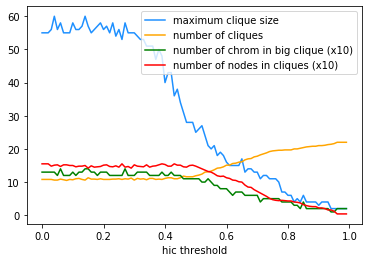

In [46]:
# Plot summary of VOTE runs
plt.figure()
plt.plot(thresh_ls, vote_results['max_clique_size'].values, 
         color='dodgerblue', label='maximum clique size')
plt.plot(thresh_ls, vote_results['n_cliques'].values/10, 
         color='orange', label='number of cliques')
plt.plot(thresh_ls, vote_results['n_chrom_big_comp'].values, 
         color='green', label='number of chrom in big clique (x10)')
plt.plot(thresh_ls, vote_results['n_nodes_cliques'].values/10, 
         color='red', label='number of nodes in cliques (x10)')
plt.xlabel('hic threshold')
plt.ylabel('')
plt.legend(loc='upper right')
plt.show()

### Cluster the network with weighted correlation clustering

In [47]:
# Select only top intraX edges
t = 0.62
adhesome_intraX_edge_list_1 = adhesome_intraX_edge_list[['source','target','hic','scaled_hic']]
adhesome_intraX_edge_list_1 = adhesome_intraX_edge_list_1[adhesome_intraX_edge_list_1['scaled_hic']>t]
# Select only top interX edges
adhesome_interX_edge_list_1 = adhesome_interX_edge_list[adhesome_interX_edge_list['scaled_hic']>t]
# Combine intraX and interX edge lists
adhesome_edge_list = pd.concat([adhesome_intraX_edge_list_1,adhesome_interX_edge_list_1])
adhesome_edge_list = adhesome_edge_list.sort_values(by=['source','target'])
adhesome_edge_list = adhesome_edge_list[adhesome_edge_list['source']!=adhesome_edge_list['target']]

In [48]:
# Create corresponding network
G = nx.from_pandas_edgelist(adhesome_edge_list, edge_attr=['hic','scaled_hic'])
G.add_nodes_from(adhesome_genes)
print('Total number of nodes in G = '+str(len(G.nodes)))
print('Total number of edges in G = '+str(len(G.edges)))
print('Average node degree in G = '+str(np.mean(list(dict(G.degree).values()))))
print('Number of connected components in G = '+str(nx.number_connected_components(G)))
print('Size of connected components = '+str([len(c) for c in nx.connected_components(G)]))
pickle.dump(G, open('graph_0.pkl', 'wb'))

Total number of nodes in G = 222
Total number of edges in G = 806
Average node degree in G = 7.261261261261262
Number of connected components in G = 98
Size of connected components = [116, 2, 3, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


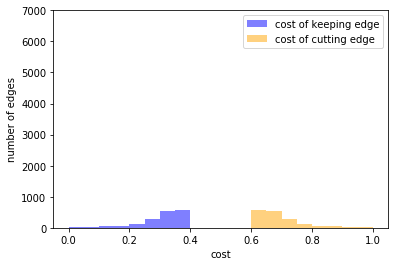

In [49]:
# Get cost matrices
A, w_plus, w_minus, w_pm = cc.compute_costs(G, 'scaled_hic')
n = G.number_of_nodes()
# Plot histogram of costs
plt.figure()
plt.hist(w_minus[np.nonzero(w_plus)], bins=np.arange(0,1.05,0.05), 
         color='blue', alpha=0.5, label='cost of keeping edge')
plt.hist(w_plus[np.nonzero(w_plus)], bins=np.arange(0,1.05,0.05), 
         color='orange', alpha=0.5, label='cost of cutting edge')
plt.ylim(0,7000)
plt.xlabel('cost')
plt.ylabel('number of edges')
plt.legend()
plt.show()

100%|██████████| 100/100 [00:12<00:00,  7.88it/s]


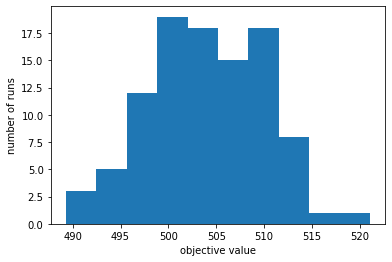

In [50]:
# Run VOTE
vote_dict,objective_vals = cc.VOTE(n, w_minus, w_plus, w_pm, n_runs=100, seed=13)
# Histogram of objectives from the runs
plt.figure()
plt.hist(objective_vals)
plt.xlabel('objective value')
plt.ylabel('number of runs')
plt.show()

In [52]:
# Run BOEM
boem_dict = cc.BOEM(vote_dict, G.number_of_nodes(), w_minus, w_plus, max_iter=100)
pickle.dump(boem_dict, open('boem_dict.pkl', 'wb'))

  0%|          | 0/222 [00:00<?, ?it/s]

VOTE objective = 489.28483138069976


  0%|          | 0/222 [00:00<?, ?it/s]

VOTE+BOEM 1 objective = 487.6064417819515


  0%|          | 0/222 [00:00<?, ?it/s]

VOTE+BOEM 2 objective = 486.9180569704812


  0%|          | 0/222 [00:00<?, ?it/s]

VOTE+BOEM 3 objective = 485.98520762383447


  0%|          | 0/222 [00:00<?, ?it/s]

VOTE+BOEM 4 objective = 485.6203006890818


  0%|          | 0/222 [00:00<?, ?it/s]

VOTE+BOEM 5 objective = 485.2390935059417


  0%|          | 0/222 [00:00<?, ?it/s]

VOTE+BOEM 6 objective = 484.49669556069944


  0%|          | 0/222 [00:00<?, ?it/s]

VOTE+BOEM 7 objective = 484.1635532702337


  0%|          | 0/222 [00:00<?, ?it/s]

VOTE+BOEM 8 objective = 483.83710797003937


  0%|          | 0/222 [00:00<?, ?it/s]

VOTE+BOEM 9 objective = 483.56986788929487


  0%|          | 0/222 [00:00<?, ?it/s]

VOTE+BOEM 10 objective = 483.3093558001737


  0%|          | 0/222 [00:00<?, ?it/s]

VOTE+BOEM 11 objective = 483.2425628094174


  0%|          | 0/222 [00:00<?, ?it/s]

VOTE+BOEM 12 objective = 483.17898407394824


  0%|          | 0/222 [00:00<?, ?it/s]

VOTE+BOEM 13 objective = 483.1357632846144


  0%|          | 0/222 [00:00<?, ?it/s]

VOTE+BOEM 14 objective = 483.11582535834


  0%|          | 0/222 [00:00<?, ?it/s]

VOTE+BOEM 15 objective = 482.8674151002013


100%|██████████| 222/222 [01:01<00:00,  3.63it/s]


In [53]:
# Load results
best_dict = pickle.load(open('boem_dict.pkl', 'rb'))
print('Final VOTE/BOEM objective = '+str(cc.compute_objective_from_dict(best_dict, w_minus, w_plus)))

Final VOTE/BOEM objective = 482.8674151002013


In [54]:
# Result of VOTE+BOEM
k = len(np.unique(list(best_dict.values())))
c_mat = np.matrix(np.concatenate([np.eye(1,k,best_dict[i]) for i in range(n)],axis=0))
x_boem = np.array(c_mat*np.transpose(c_mat))
labels = list(G.nodes)
x_df = pd.DataFrame(x_boem, index=labels, columns=labels)

In [55]:
# Final clique graph
np.fill_diagonal(x_df.values, 0)
clique_graph = nx.from_pandas_adjacency(x_df)
# Add cluster information for each node
nx.set_node_attributes(clique_graph, {labels[i]: str(int(best_dict[i])) for i in range(n)}, "cluster")
# Add chromosome information for each node
nx.set_node_attributes(clique_graph, {labels[i]: adhesome_chr_loci[adhesome_chr_loci['gene']==labels[i]]['chrom'].values[0] for i in range(n)}, "chromosome")
# Add functional category for each node
nx.set_node_attributes(clique_graph, {labels[i]: df_components[df_components['geneSymbol']==labels[i]]['functionalCategory'].values[0] 
                                      for i in range(n)}, "function")
# Add scaled HiC information
edgelist_clique = list(clique_graph.edges)
nx.set_edge_attributes(clique_graph, 
                       {edge: G[edge[0]][edge[1]]['scaled_hic'] for edge in G.edges}, 
                       'scaled_hic')
nx.set_edge_attributes(clique_graph, 
                       {edge: 1-G[edge[0]][edge[1]]['scaled_hic'] for edge in G.edges}, 
                       'reciprocal_scaled_hic')

In [61]:
# Clique graph summary
print('Total number of nodes in clique_graph = '+str(len(clique_graph.nodes)))
print('Total number of edges in clique_graph = '+str(len(clique_graph.edges)))
print('Average node degree in clique_graph = '+str(np.mean(list(dict(clique_graph.degree).values()))))
print('Number of connected components in clique_graph = '+str(nx.number_connected_components(clique_graph)))
print('Size of connected components = '+str(sorted([len(c) for c in nx.connected_components(clique_graph)], reverse=True)))
print('Number of nodes in non trivial cliques = '+str(sum([len(c) for c in nx.connected_components(clique_graph) if len(c)>1])))
# Save network to html
oi.output_networkx_graph_as_interactive_html(clique_graph, filename=saving_dir+"clique_graph.html")

Total number of nodes in clique_graph = 222
Total number of edges in clique_graph = 191
Average node degree in clique_graph = 1.7207207207207207
Number of connected components in clique_graph = 153
Size of connected components = [16, 4, 4, 4, 4, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Number of nodes in non trivial cliques = 111


PosixPath('/home/louiscam/projects/gpcr/save/figures/clique_graph.html')

In [62]:
# Select only components with more than 1 node
selected_nodes = np.sum([list(cc) for cc in nx.connected_components(clique_graph) if len(cc)>1])
clique_subgraph = clique_graph.subgraph(selected_nodes)
# Save network to html
oi.output_networkx_graph_as_interactive_html(clique_subgraph, filename=saving_dir+"clique_subgraph.html")

PosixPath('/home/louiscam/projects/gpcr/save/figures/clique_subgraph.html')

### Isolate big cluster

In [63]:
# Isolate big cluster
nodes_in_big_component = sorted(nx.connected_components(clique_graph), key=len, reverse=True)[0]
big_component = G.subgraph(nodes_in_big_component)
print('Total number of nodes in big_component = '+str(len(big_component.nodes)))
print('Total number of edges in big_component = '+str(len(big_component.edges)))
print('Average node degree in big_component = '+str(np.mean(list(dict(big_component.degree).values()))))
print('Number of connected components in big_component = '+str(nx.number_connected_components(big_component)))
print('Size of connected components = '+str([len(c) for c in nx.connected_components(big_component)]))
pickle.dump(big_component, open('big_component.pkl', 'wb'))

Total number of nodes in big_component = 16
Total number of edges in big_component = 105
Average node degree in big_component = 13.125
Number of connected components in big_component = 1
Size of connected components = [16]


In [70]:
# Nodes in big cluster
sorted(nodes_in_big_component)

['CAPN1',
 'CD151',
 'CFL1',
 'CRK',
 'ENG',
 'HRAS',
 'ITGB4',
 'MAPK8IP3',
 'PDPK1',
 'PKD1',
 'PLEC',
 'SHARPIN',
 'SLC16A3',
 'STAT3',
 'TUBA1B',
 'VASP']

### Can we further cluster the big cluster?

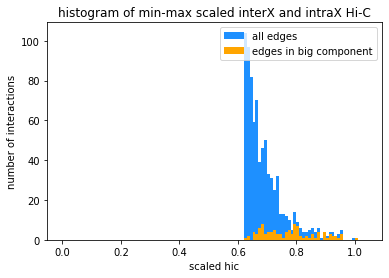

In [65]:
plt.figure()
plt.hist(adhesome_edge_list['scaled_hic'].values, bins=np.arange(0,1.05,0.01), 
         color='dodgerblue', label='all edges')
plt.hist(list(nx.get_edge_attributes(big_component,'scaled_hic').values()), bins=np.arange(0,1.05,0.01),
        color='orange', label='edges in big component')
plt.xlabel('scaled hic')
plt.ylabel('number of interactions')
plt.title('histogram of min-max scaled interX and intraX Hi-C')
plt.legend(loc='upper right')
plt.show()

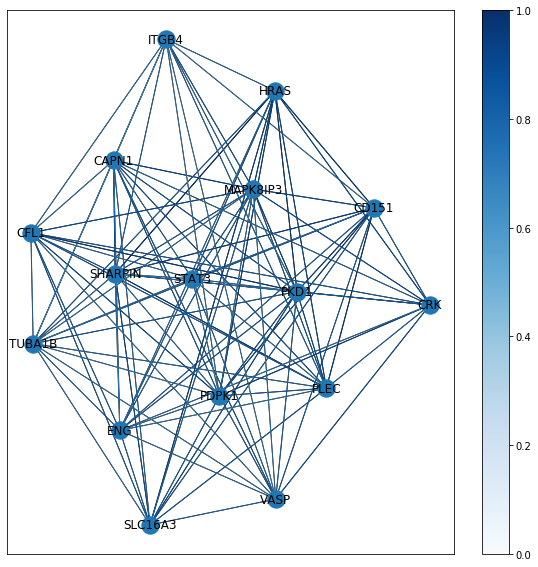

In [68]:
# Visualize big cluster
# Prune low weight edges
edge_weights = nx.get_edge_attributes(big_component,'scaled_hic')
big_component_reduced = big_component.copy()
big_component_reduced.remove_edges_from((e for e, w in edge_weights.items() if w < 0.5))

plt.figure(figsize=(10,10))
pos=nx.spring_layout(big_component_reduced, k=1, iterations=20)

# Plot nodes
nx.draw_networkx(big_component_reduced,pos)

# Plot edges
edges = nx.draw_networkx_edges(big_component_reduced, pos, 
                       width=list(nx.get_edge_attributes(big_component_reduced,'scaled_hic').values()),
                       edge_cmap=plt.cm.Blues,
                       edge_color=list(nx.get_edge_attributes(big_component_reduced,'scaled_hic').values()),
                       edge_vmin=0, edge_vmax=1)
plt.colorbar(edges)
plt.show()


### Connectivity between clusters

In [116]:
# Create dataframe of clusters
cluster_dict = {labels[k]:v for k,v in best_dict.items()}
clusters_df0 = pd.DataFrame({'gene':list(cluster_dict.keys()), 
                            'cluster':list(cluster_dict.values()),
                            'loci': [adhesome_gene_locus_dict[gene].split('_x_') for gene in cluster_dict.keys()]})
clusters_df = clusters_df0[['gene','cluster']].groupby('cluster')['gene'].apply(list).to_frame()
clusters_df['n_genes'] = [len(cluster) for cluster in clusters_df['gene'].values]
clusters_df = clusters_df[clusters_df['n_genes']>1]
clusters_df = clusters_df.sort_index()
pickle.dump(clusters_df, open(saving_dir+'clusters_fig1.pkl', 'wb'))
print('Number of selected clusters = '+str(len(clusters_df)))

Number of selected clusters = 42


In [117]:
# Create full adhesome gene edge list (no thresholding)
adhesome_intraX_edge_list_2 = adhesome_intraX_edge_list[['source','target','hic','scaled_hic']]
# Select only top interX edges
adhesome_interX_edge_list_2 = adhesome_interX_edge_list
# Combine intraX and interX edge lists
adhesome_edge_list_2 = pd.concat([adhesome_intraX_edge_list_2,adhesome_interX_edge_list_2])
adhesome_edge_list_2 = adhesome_edge_list_2.sort_values(by=['source','target'])
adhesome_edge_list_2 = adhesome_edge_list_2[adhesome_edge_list_2['source']!=adhesome_edge_list_2['target']]

In [118]:
# Create cluster adjacency matrix
selected_clusters = list(clusters_df.index)
cluster_adj = pd.DataFrame(0, columns=selected_clusters, index=selected_clusters)
# Fill out each entry
for i in selected_clusters:
    for j in selected_clusters:
        genes_i = clusters_df.loc[i,'gene']
        genes_j = clusters_df.loc[j,'gene']
        inter_cluster_edges = adhesome_edge_list_2[(adhesome_edge_list_2['source'].isin(genes_i) 
                                                  & adhesome_edge_list_2['target'].isin(genes_j)) |
                                                 (adhesome_edge_list_2['source'].isin(genes_j) 
                                                  & adhesome_edge_list_2['target'].isin(genes_i))]
        cluster_adj.loc[i,j] = inter_cluster_edges['scaled_hic'].values.mean()
# cluster_adj.columns = np.array(selected_clusters, dtype='str')
# cluster_adj.index = np.array(selected_clusters, dtype='str')

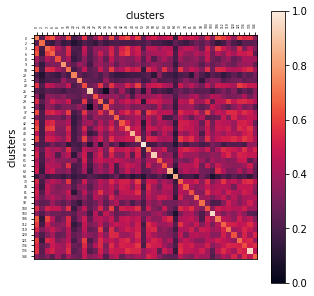

In [119]:
# Visualize connctivity between clusters
lu.plot_heatmap(cluster_adj, selected_clusters, selected_clusters, 'clusters', 'clusters', 
                5,1)

In [131]:
# Create network of clusters
cluster_adj1 = cluster_adj.copy()
np.fill_diagonal(cluster_adj1.values,0)
cluster_adj1 = (cluster_adj1>0.5)*cluster_adj1
clusters_net = nx.from_pandas_adjacency(cluster_adj1)
# Add node attribute: adhesome genes in each cluster
nx.set_node_attributes(clusters_net, {c: clusters_df.loc[c,'gene'] for c in clusters_df.index}, "genes")
# Add node attribute: number of adhesome genes in each cluster
nx.set_node_attributes(clusters_net, {c: clusters_df.loc[c,'n_genes'] for c in clusters_df.index}, "n_genes")
# Add node attribute: average within-cluster HiC
nx.set_node_attributes(clusters_net, {c: cluster_adj.loc[c,c] for c in clusters_df.index}, "avg_hic")

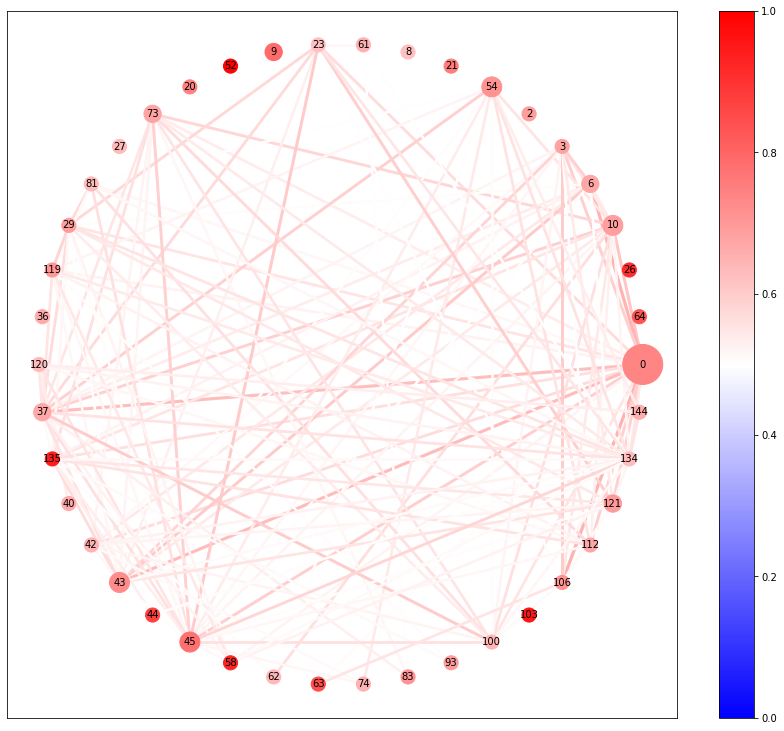

In [133]:
# Visualize big cluster
plt.figure(figsize=(15,13))
pos = nx.circular_layout(clusters_net, scale=2) #nx.spring_layout(clusters_net, k=1, iterations=20)

# Plot nodes
nodes = nx.draw_networkx_nodes(clusters_net, pos, 
                               node_size=100*np.array(list(nx.get_node_attributes(clusters_net,'n_genes').values())),
                               cmap=plt.cm.bwr,
                               node_color = list(nx.get_node_attributes(clusters_net,'avg_hic').values()),
                               vmin=0, vmax=1)
nx.draw_networkx_labels(clusters_net, pos, font_size=10)

# Plot edges
edges = nx.draw_networkx_edges(clusters_net, pos, 
                       width=5*np.array(list(nx.get_edge_attributes(clusters_net,'weight').values())),
                       edge_cmap=plt.cm.bwr,
                       edge_color=list(nx.get_edge_attributes(clusters_net,'weight').values()),
                       edge_vmin=0, edge_vmax=1)
plt.colorbar(edges)
plt.show()

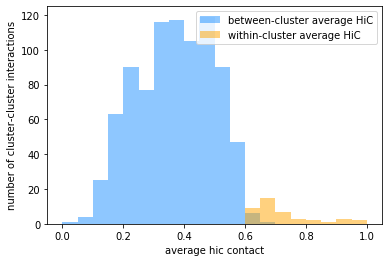

In [97]:
# Visualize histogram of within-cluster average HiC versus between-cluster HI-C
plt.figure()
plt.hist(cluster_adj.values[np.triu_indices(len(cluster_adj),1)], 
         bins=np.arange(0,1.05,0.05), color='dodgerblue', alpha=0.5, label='between-cluster average HiC')
plt.hist(np.diagonal(cluster_adj), 
         bins=np.arange(0,1.05,0.05), color='orange', alpha=0.5, label='within-cluster average HiC')
plt.xlabel('average hic contact')
plt.ylabel('number of cluster-cluster interactions')
plt.legend()
plt.show()

### Plot all clusters

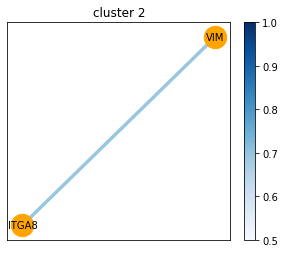

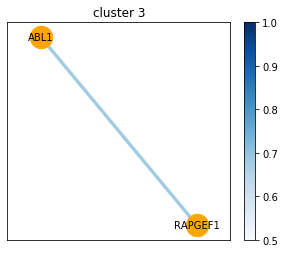

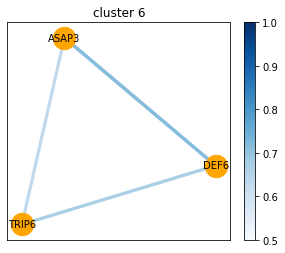

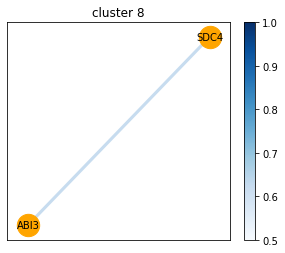

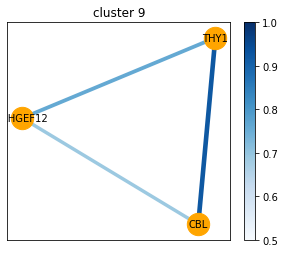

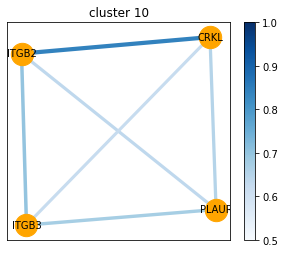

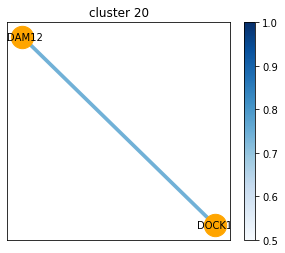

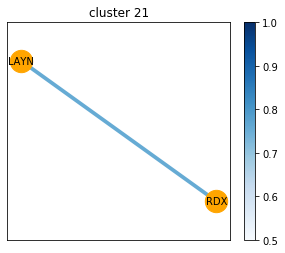

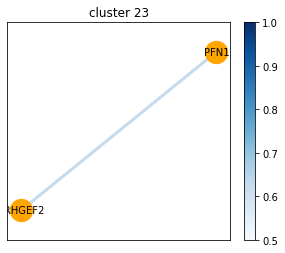

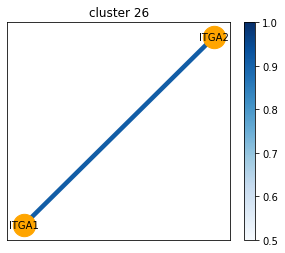

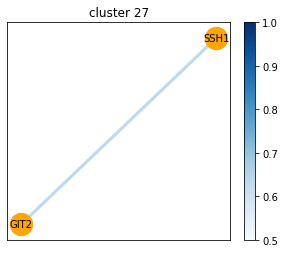

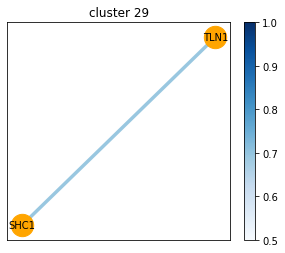

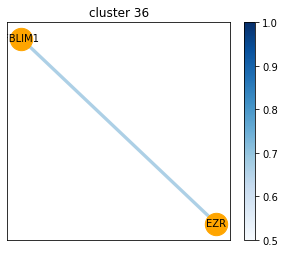

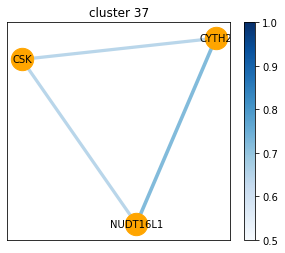

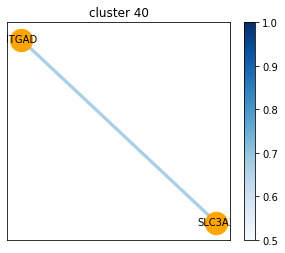

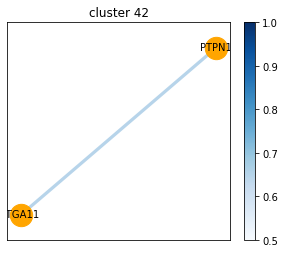

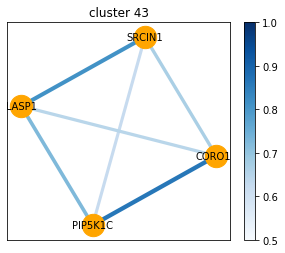

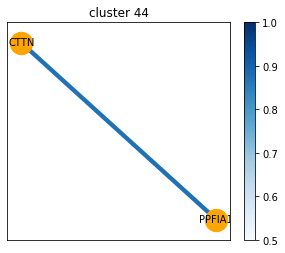

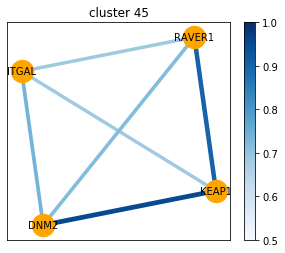

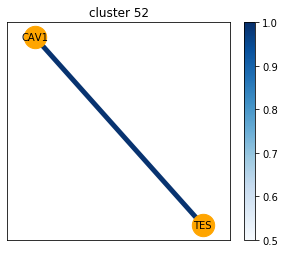

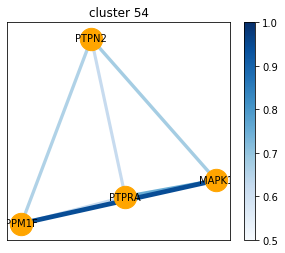

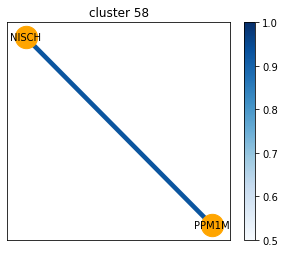

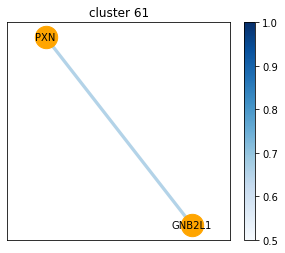

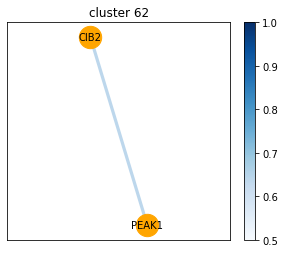

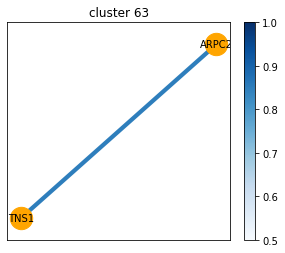

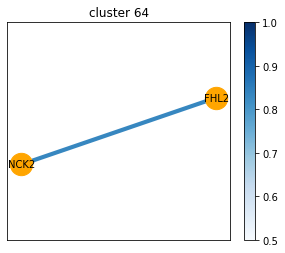

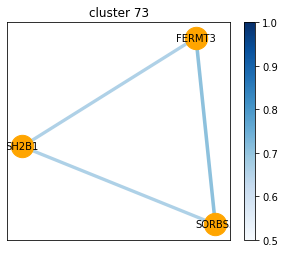

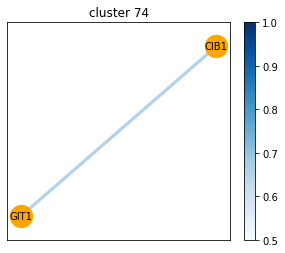

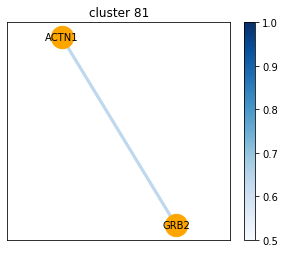

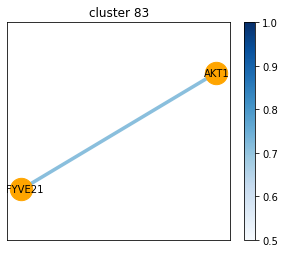

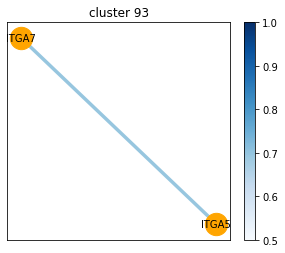

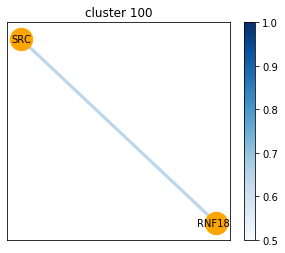

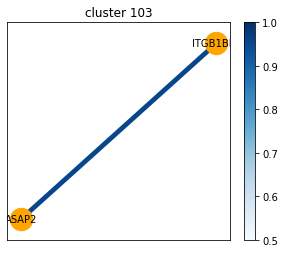

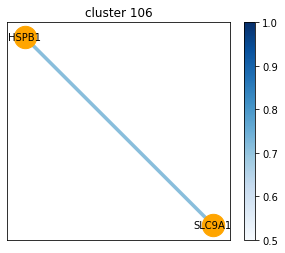

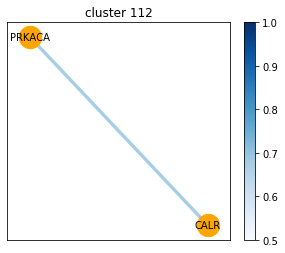

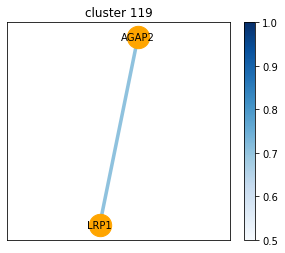

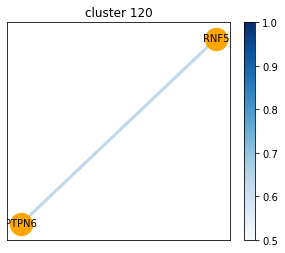

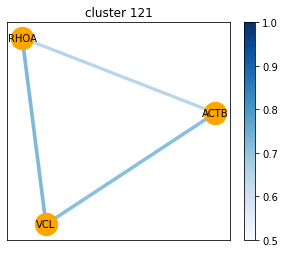

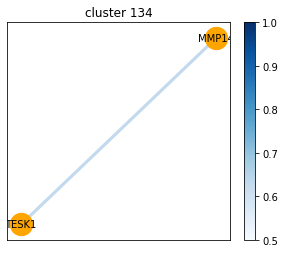

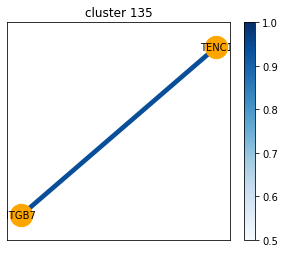

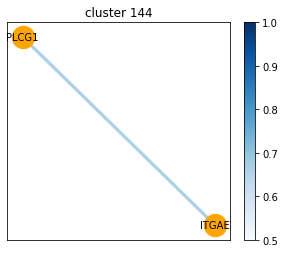

In [169]:
# Plot all clusters
for c in np.array(clusters_df.index)[1:]:
    cluster_tmp = clique_graph.subgraph(clusters_df.loc[c]['gene'])

    plt.figure(figsize=(5,4))
    pos=nx.spring_layout(cluster_tmp, k=0.1, iterations=20)

    # Plot nodes
    nodes = nx.draw_networkx_nodes(cluster_tmp, pos, 
                                   node_size=500, node_color='orange')
    nx.draw_networkx_labels(cluster_tmp, pos, font_size=10)

    # Plot edges
    edges = nx.draw_networkx_edges(cluster_tmp, pos, 
                           width=5*np.array(list(nx.get_edge_attributes(cluster_tmp,'scaled_hic').values())),
                           edge_cmap=plt.cm.Blues,
                           edge_color=list(nx.get_edge_attributes(cluster_tmp,'scaled_hic').values()),
                           edge_vmin=0.5, edge_vmax=1)
    plt.colorbar(edges)
    plt.title('cluster '+str(c))
    plt.show()